In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from pathlib import Path
import torch
from sklearn import metrics
from torchvision import models
from torchvision.models import MobileNet_V3_Small_Weights
from torch import nn
from model_utils import eval_per_class, eval_avg_acc
from typing import Literal


## Custom Functions

In [15]:
def csv_dirs(data_folder:str)->list:
    dirs = glob.glob(f"{Path(data_folder)/'**'}", recursive=True)
    csv_dirs = []
    for path in dirs:
        if ".csv" in path:
            csv_dirs.append(path)
    return csv_dirs


def plot_dataframe_old(df: pd.DataFrame, title: str = ""):
    epochs = df["Epoch"]
    acc = df["Accuracy"]
    loss = df["Average_loss"]
    plt.figure(figsize=(20, 20))
    plt.subplot(2, 1, 1)
    plt.title(title, fontsize=20, pad=20, fontweight="bold")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.plot(epochs, acc)
    ymin, ymax = acc.min(), acc.max()
    plt.yticks(np.linspace(ymin, ymax, 7))
    plt.grid()

    plt.subplot(2, 1, 2)
    plt.xlabel("Epoch")
    plt.ylabel("Average_loss")
    plt.plot(epochs, loss, color="r", ls="--")
    ymin, ymax = loss.min(), loss.max()
    plt.yticks(np.linspace(ymin, ymax, 7))
    plt.grid()
    plt.tight_layout()
    plt.show()


def plot_dataframe(df: pd.DataFrame, title: str = ""):
    epochs = df["Epoch"]
    cols = df.columns.to_list()
    if not "Training_accuracy" in cols:
        plot_dataframe_old(df, title)
        return
    train_acc = df["Training_accuracy"]
    train_loss = df["Training_loss"]
    val_acc = df["Validation_accuracy"]
    val_loss = df["Validation_loss"]
    plt.figure(figsize=(20, 20))
    plt.subplot(2, 1, 1)
    plt.title(title, fontsize=20,pad=20, fontweight='bold')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.plot(epochs, train_acc, label='training accuracy')
    plt.plot(epochs, val_acc, color="g", label="validation accuracy")
    plt.legend()
    amin, amax = train_acc.min(), train_acc.max()
    lmin, lmax = val_acc.min(), val_acc.max()
    plt.yticks(np.linspace(min(amin,lmin), max(amax,lmax), 7))
    plt.grid()

    plt.subplot(2, 1, 2)
    plt.xlabel("Epoch")
    plt.ylabel("Average_loss")
    plt.plot(epochs, train_loss, color="r", ls="--", label="training loss")
    plt.plot(epochs, val_loss, color="tab:orange", ls="--", label="validation loss")
    amin, amax = train_loss.min(), train_loss.max()
    lmin, lmax = val_loss.min(), val_loss.max()
    plt.legend()
    plt.yticks(np.linspace(min(amin, lmin), max(amax, lmax), 7))
    plt.grid()
    plt.tight_layout()
    plt.show()


def label_to_class(values:list[torch.Tensor], labels_map:dict)->list:
    new_values = []
    for v in values:
        new_v = labels_map[v.item()]
        new_values.append(new_v)
    return new_values


def confusion_matrix(
    title: str,
    true_values: list,
    pred_values: list,
    classes: list,
    norm: Literal["true", "pred", "all"] = None,
):
    confusion_matrix = metrics.confusion_matrix(
        true_values, pred_values, normalize=norm
    )
    cm_disp = metrics.ConfusionMatrixDisplay(
        confusion_matrix, display_labels=classes
    )
    cm_disp.plot(values_format='.2f')
    plt.title(title)
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()


def get_batch_size(file_name:str):
    tokens = file_name.split('_')
    for t in tokens:
        if "batch" in t:
            batch_token = t
    batch_size = batch_token.split(':')[1]
    return int(batch_size)

def perform_eval(model_path:str, classes:list, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = models.mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT).to(device)
    labels_map = {i:clss for i, clss in enumerate(classes, 0)}

    model.classifier[2] = nn.Dropout(p=0.5, inplace=True)
    model.classifier[3] = nn.Linear(in_features=1024, out_features=len(classes))
    model.classifier.insert(0, nn.Dropout(p=0.3, inplace=True))

    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)

    eval_avg_acc(model, data_loader)
    true_values, predicted_values = eval_per_class(data_loader, model, classes)
    true_values = label_to_class(true_values, labels_map)
    predicted_values = label_to_class(predicted_values, labels_map)
    return true_values, predicted_values

## Accuracy and Loss curves over epochs

### CIFAR10

In [ ]:

data_folder = 'output_data/mobilenet_cifar_unfrozen'
files = csv_dirs(data_folder)
for f in files:
    title = Path(f).name.strip('.csv')
    df = pd.read_csv(f)
    plot_dataframe(df, title)

### Wheat data

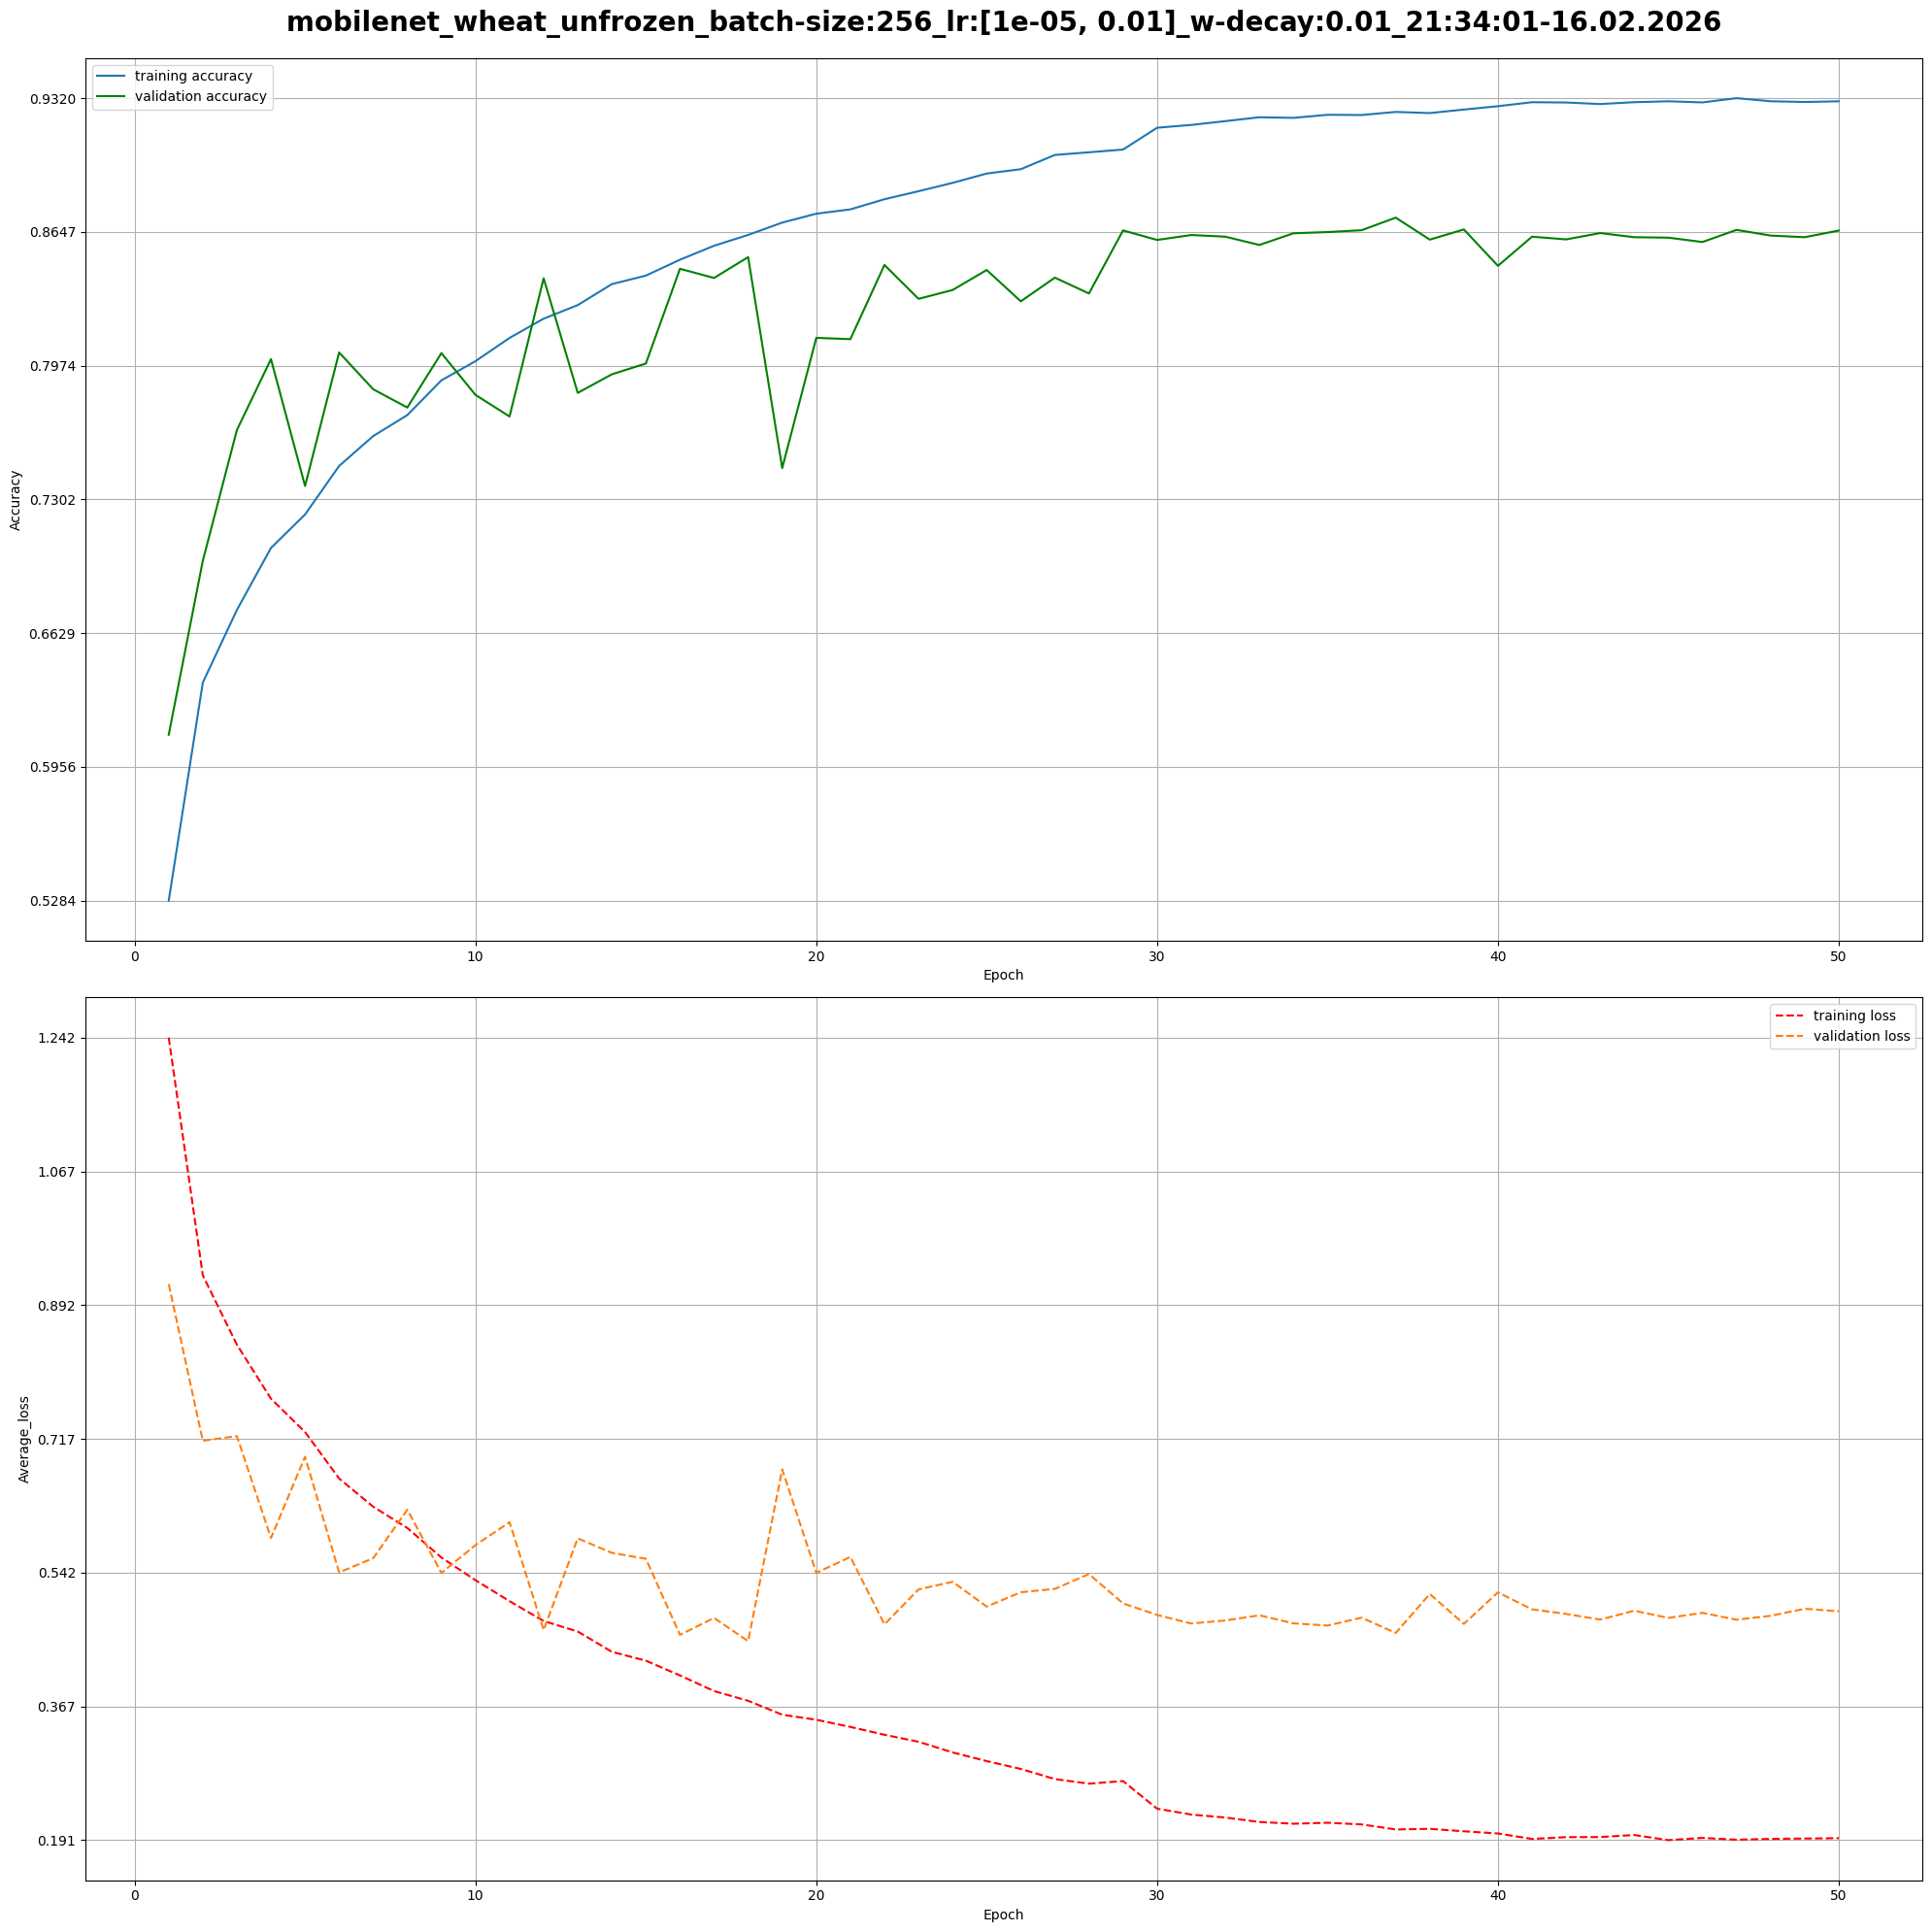

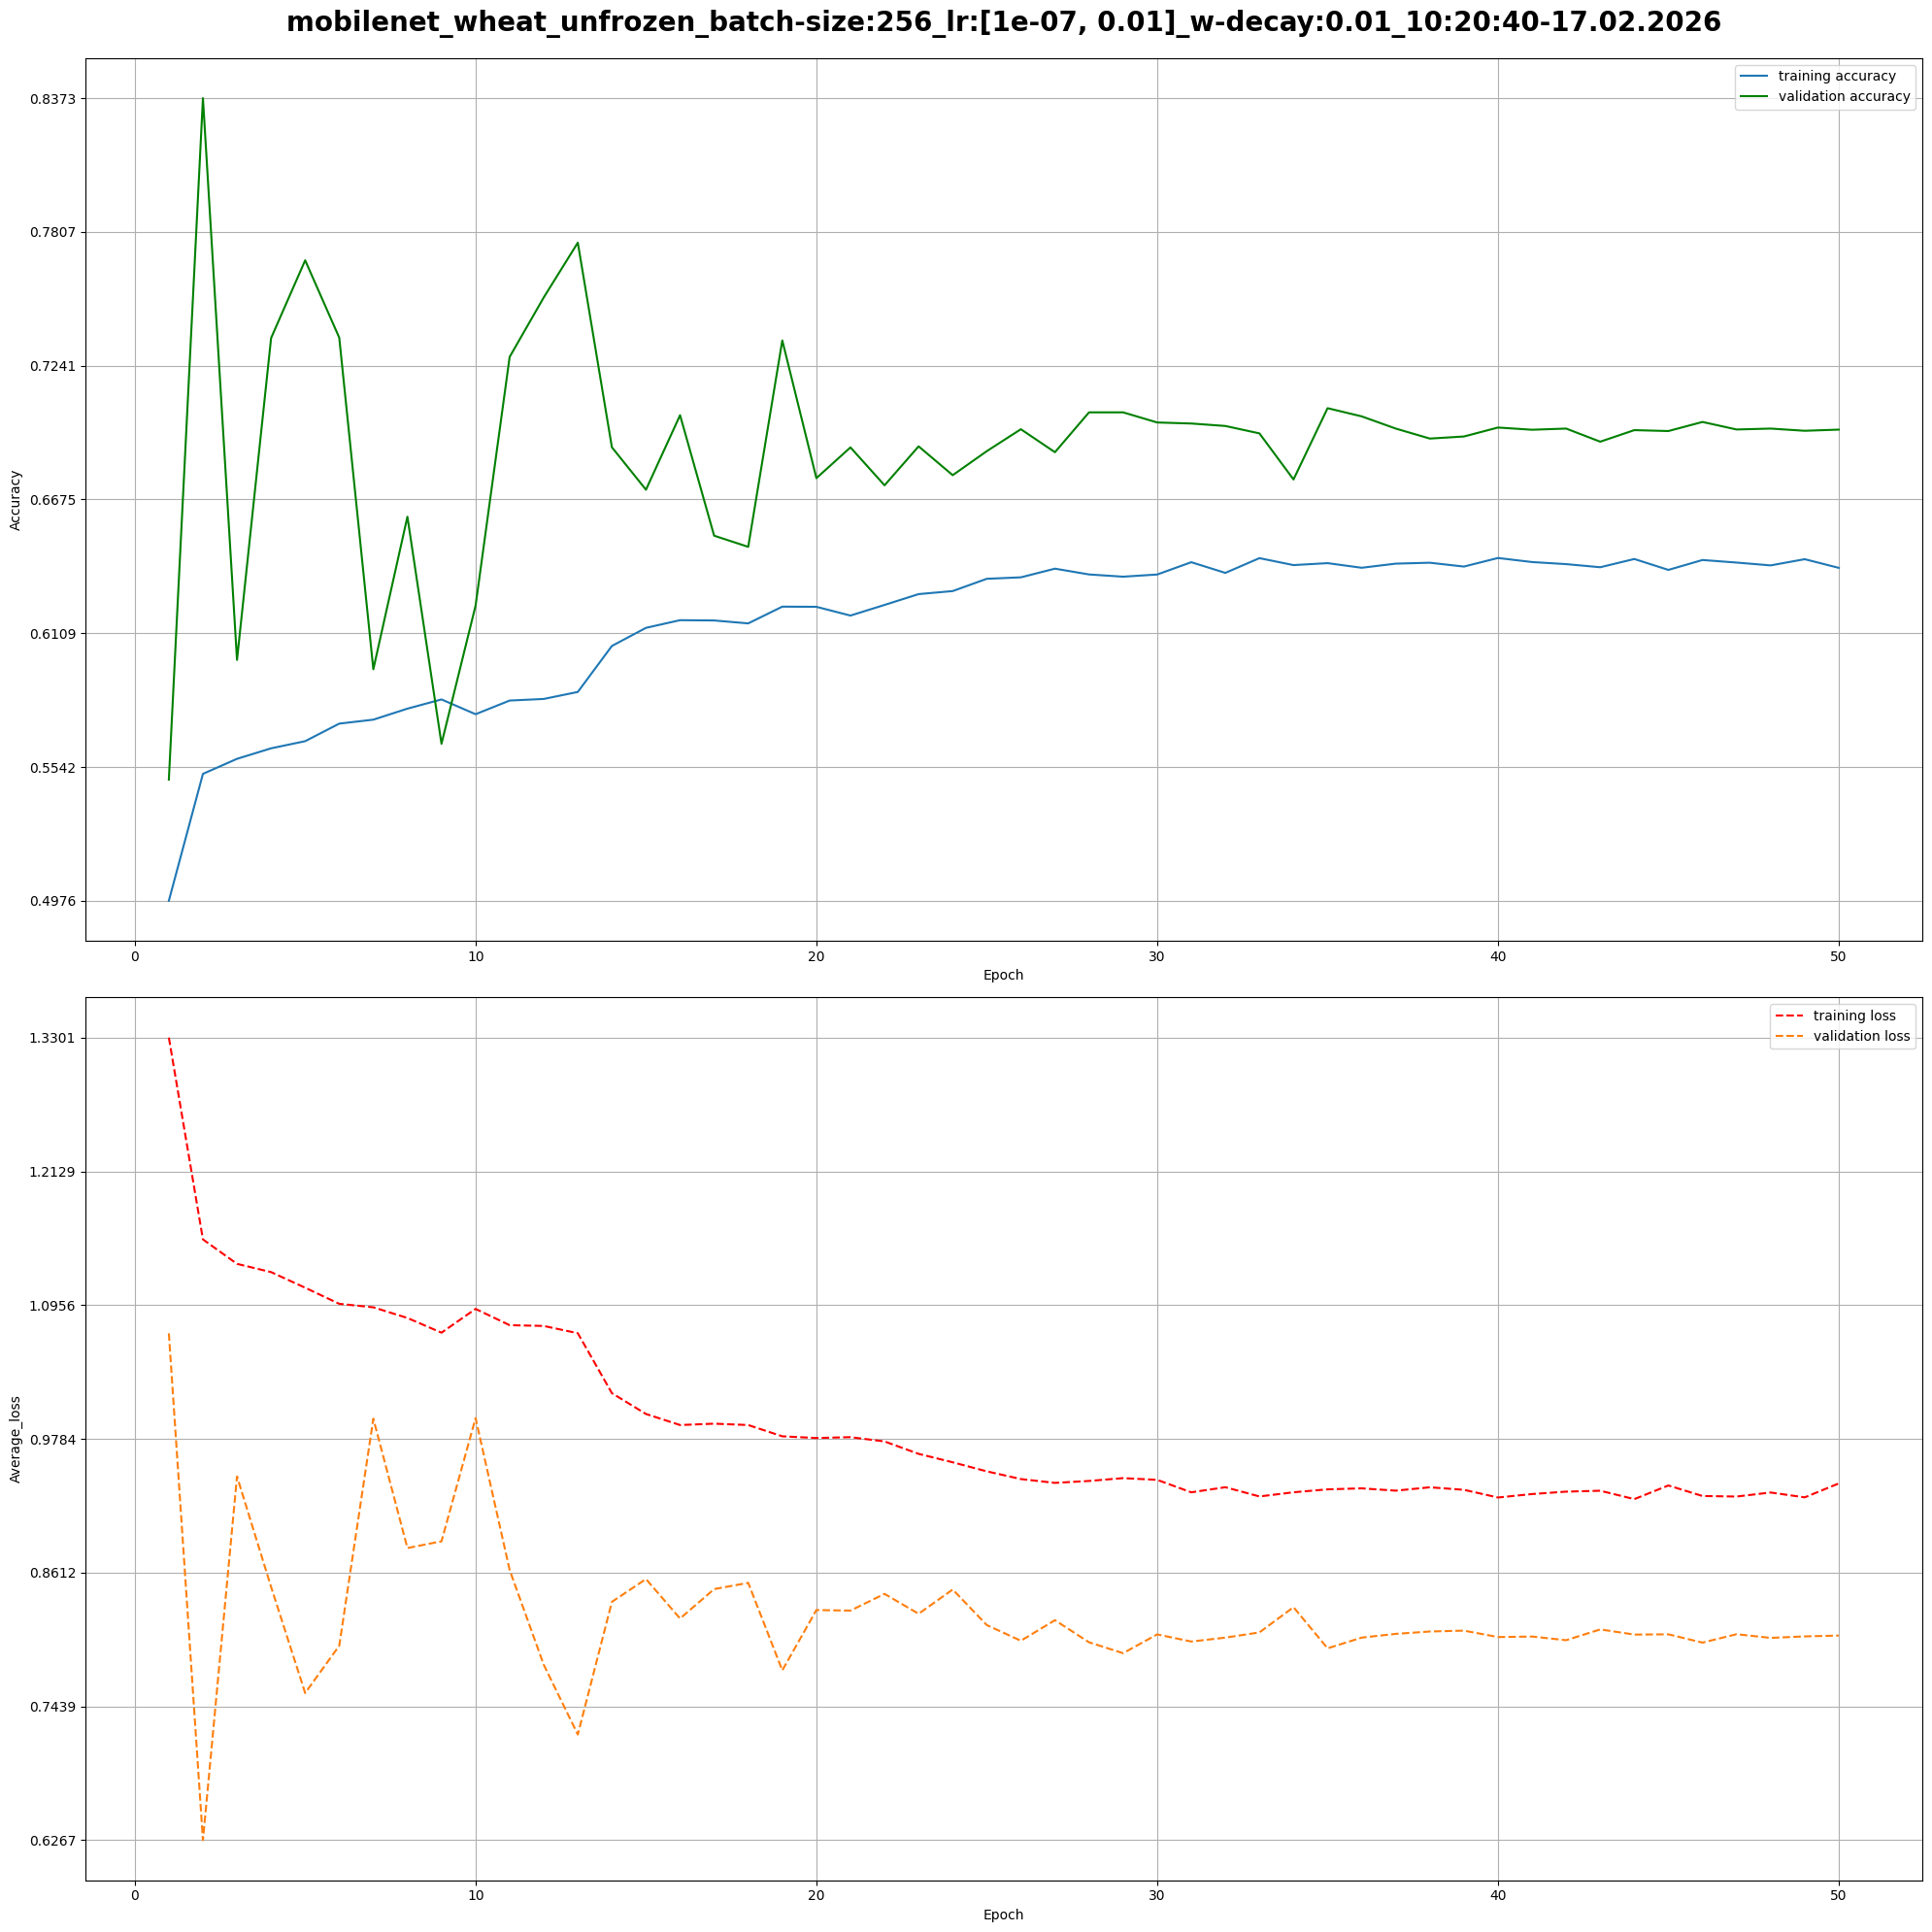

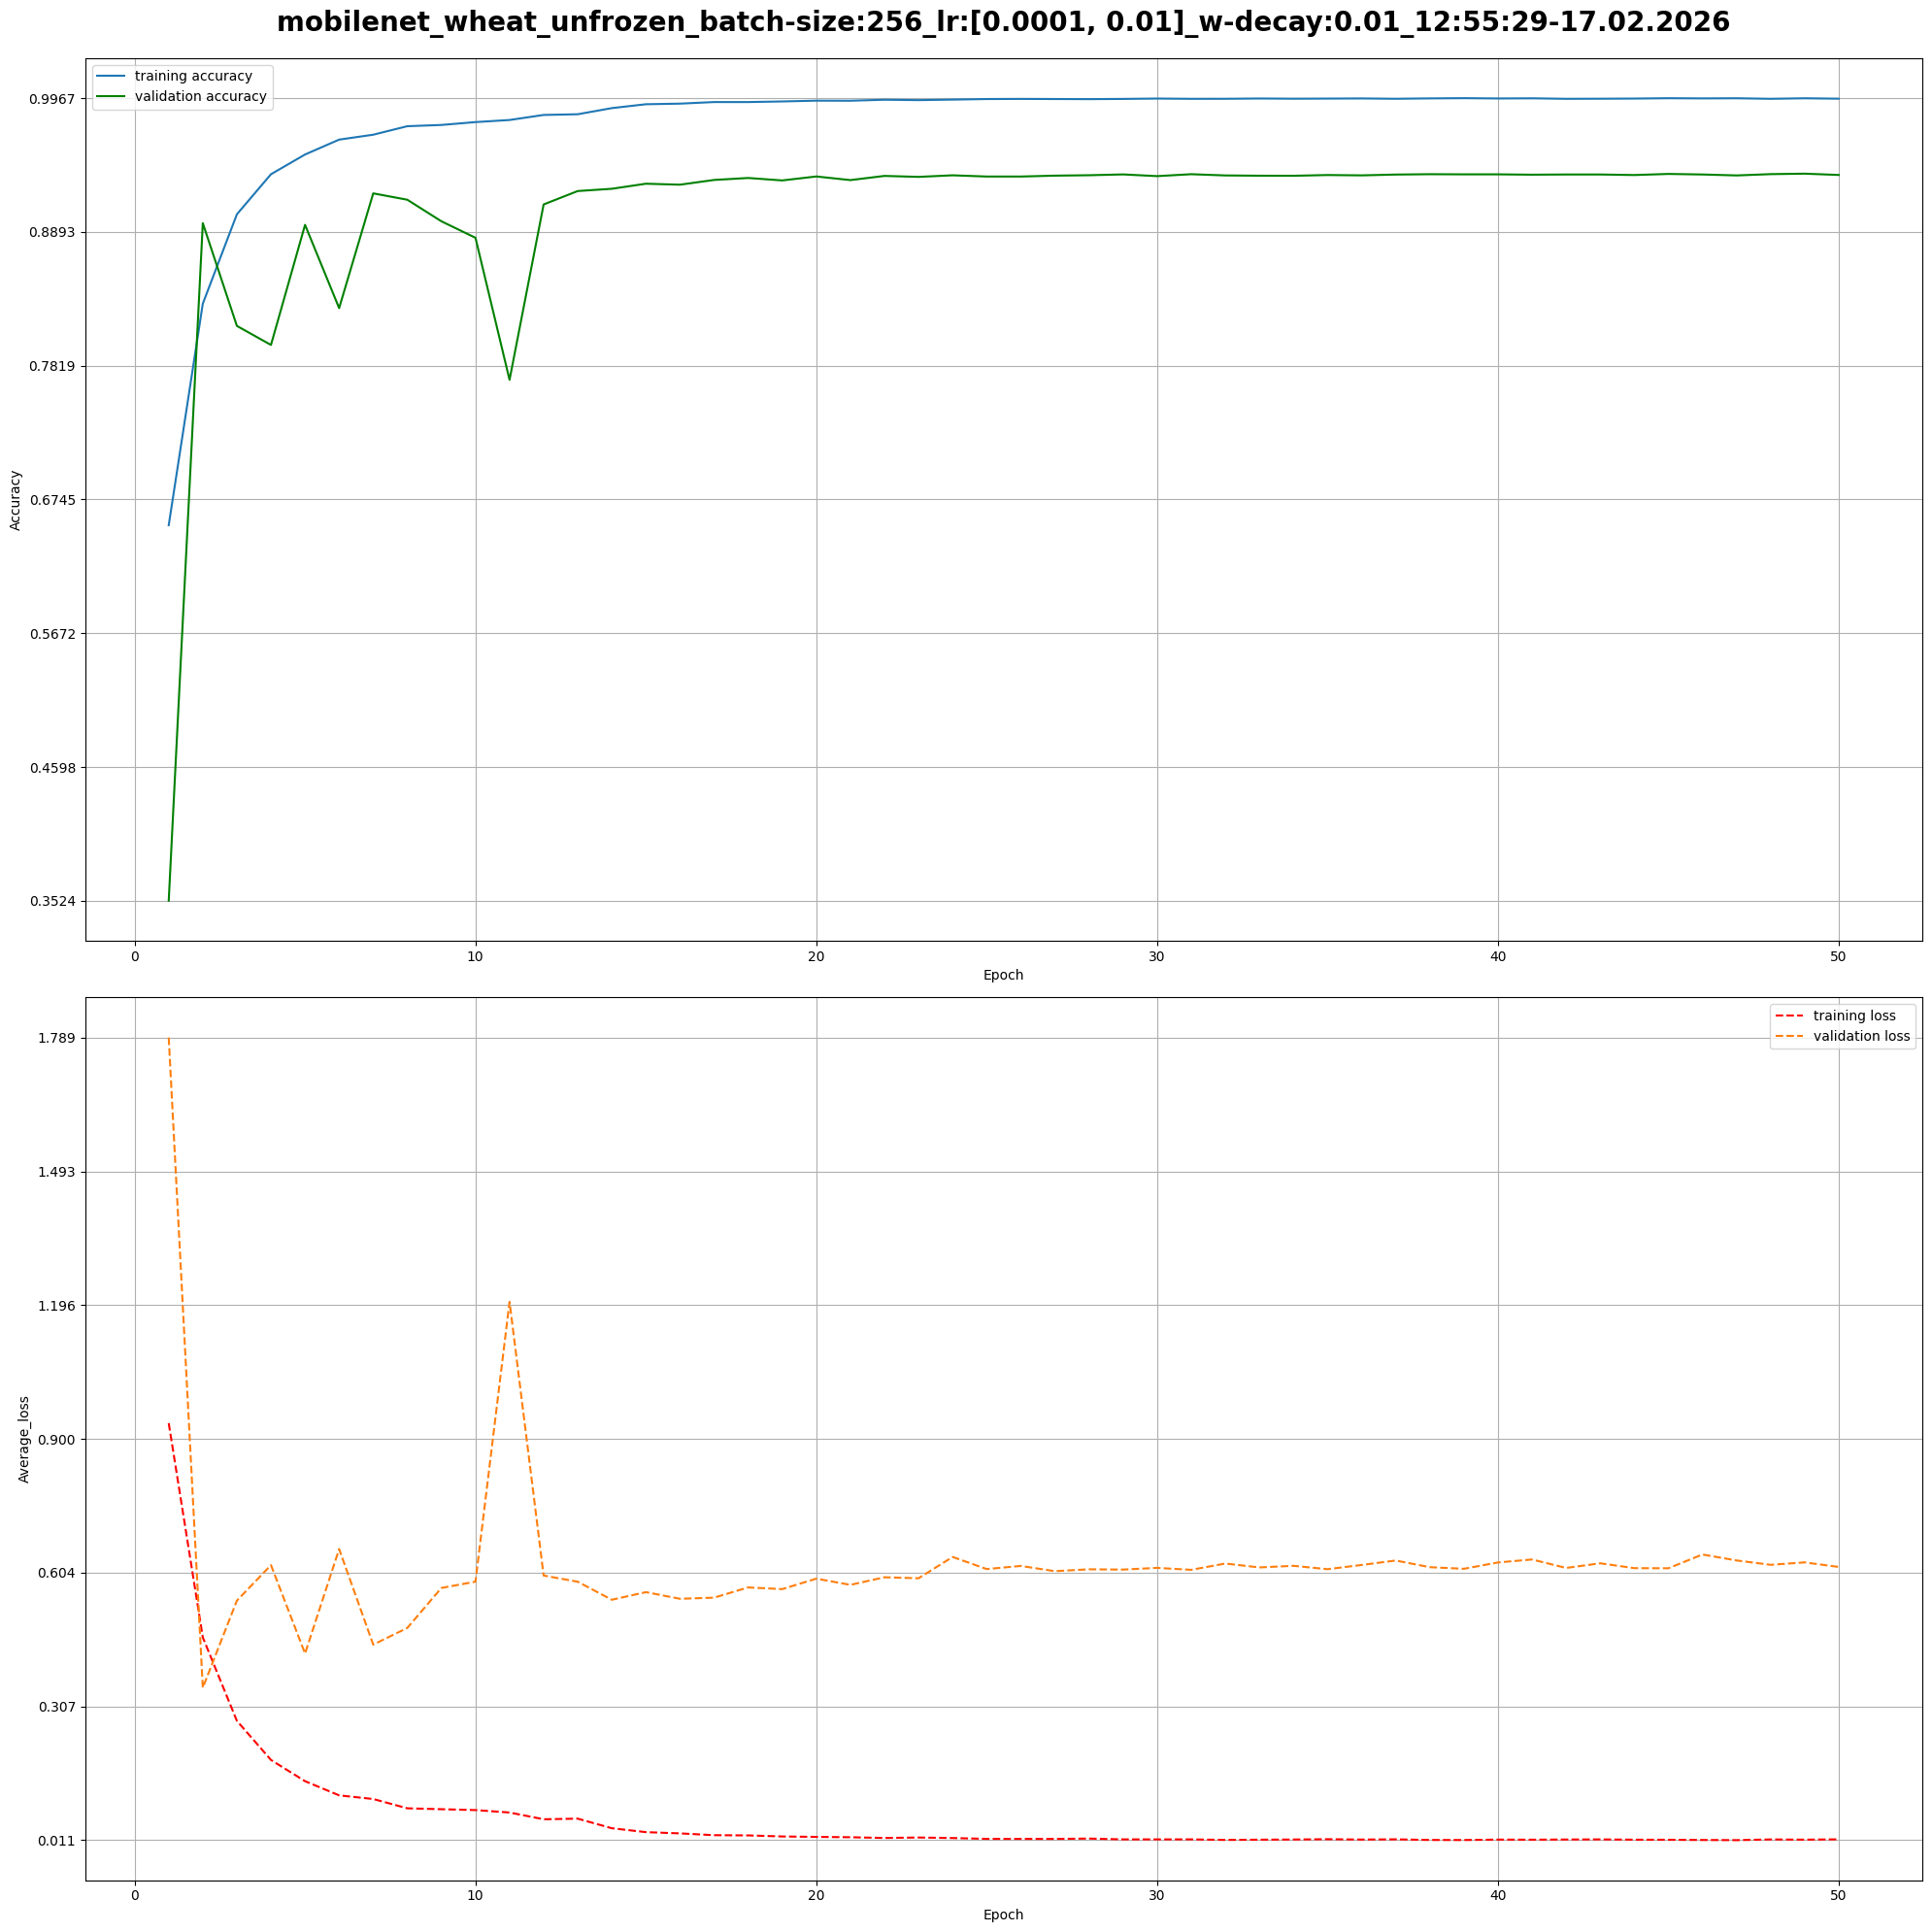

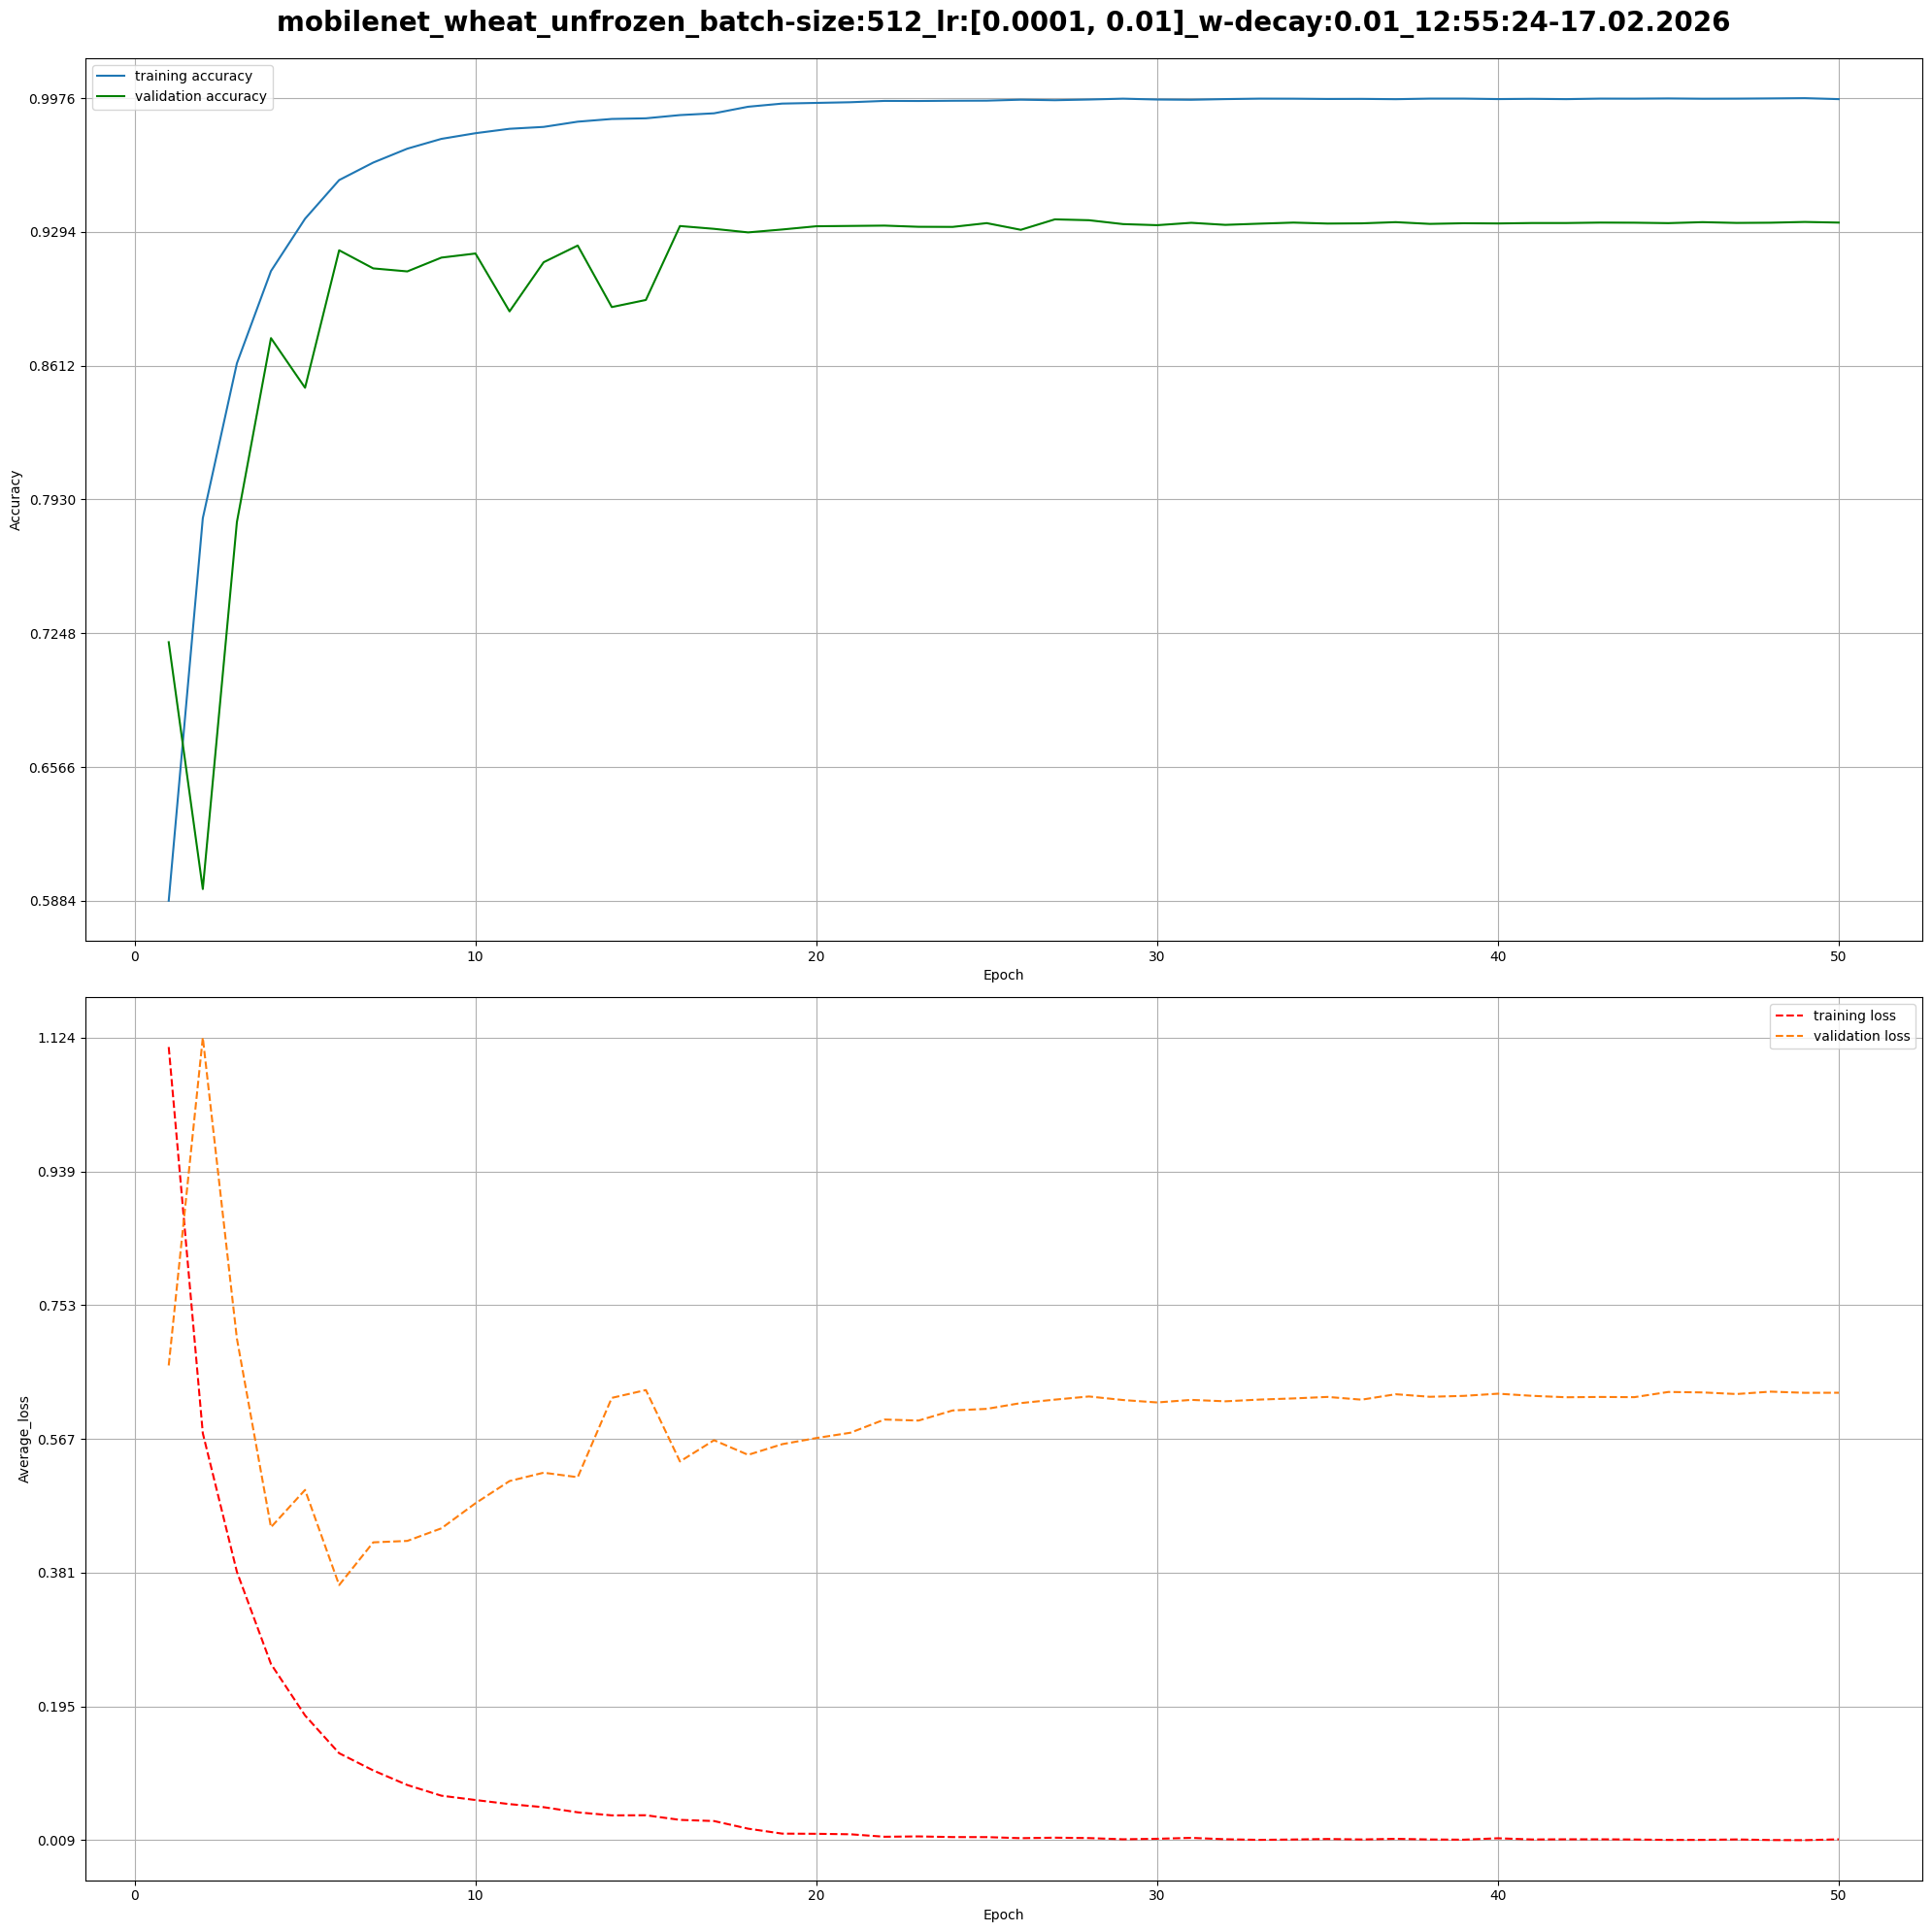

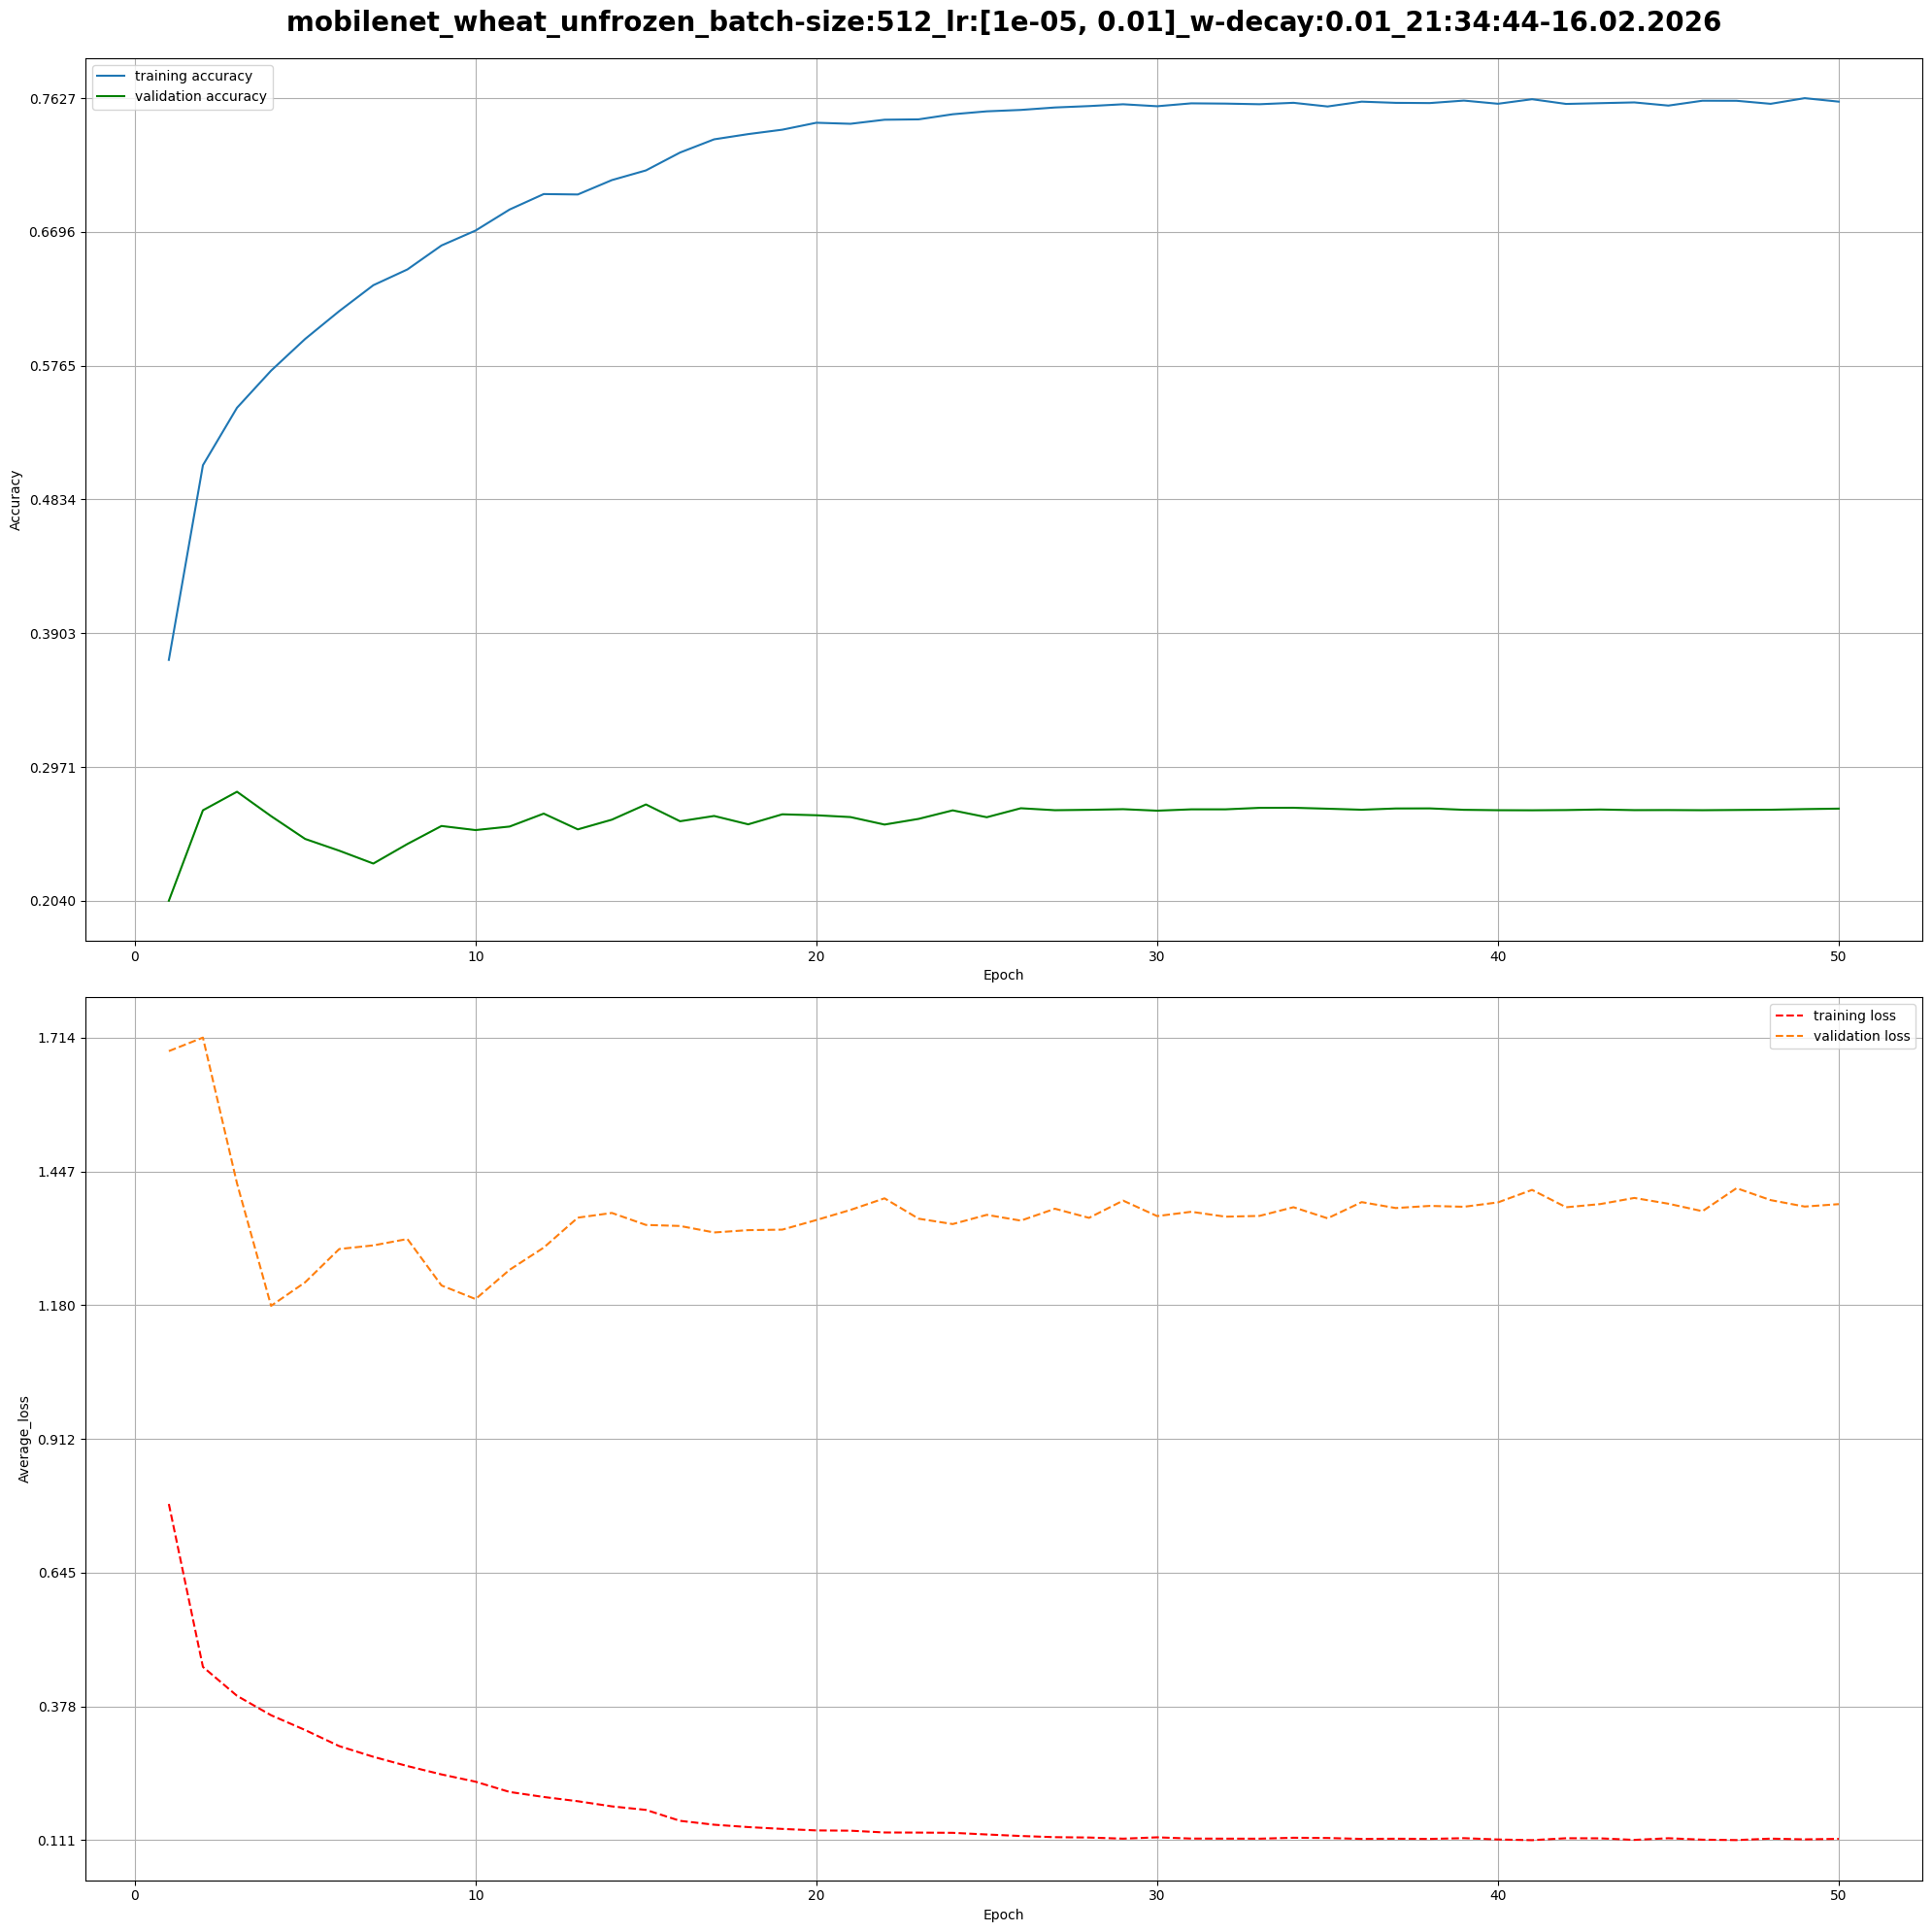

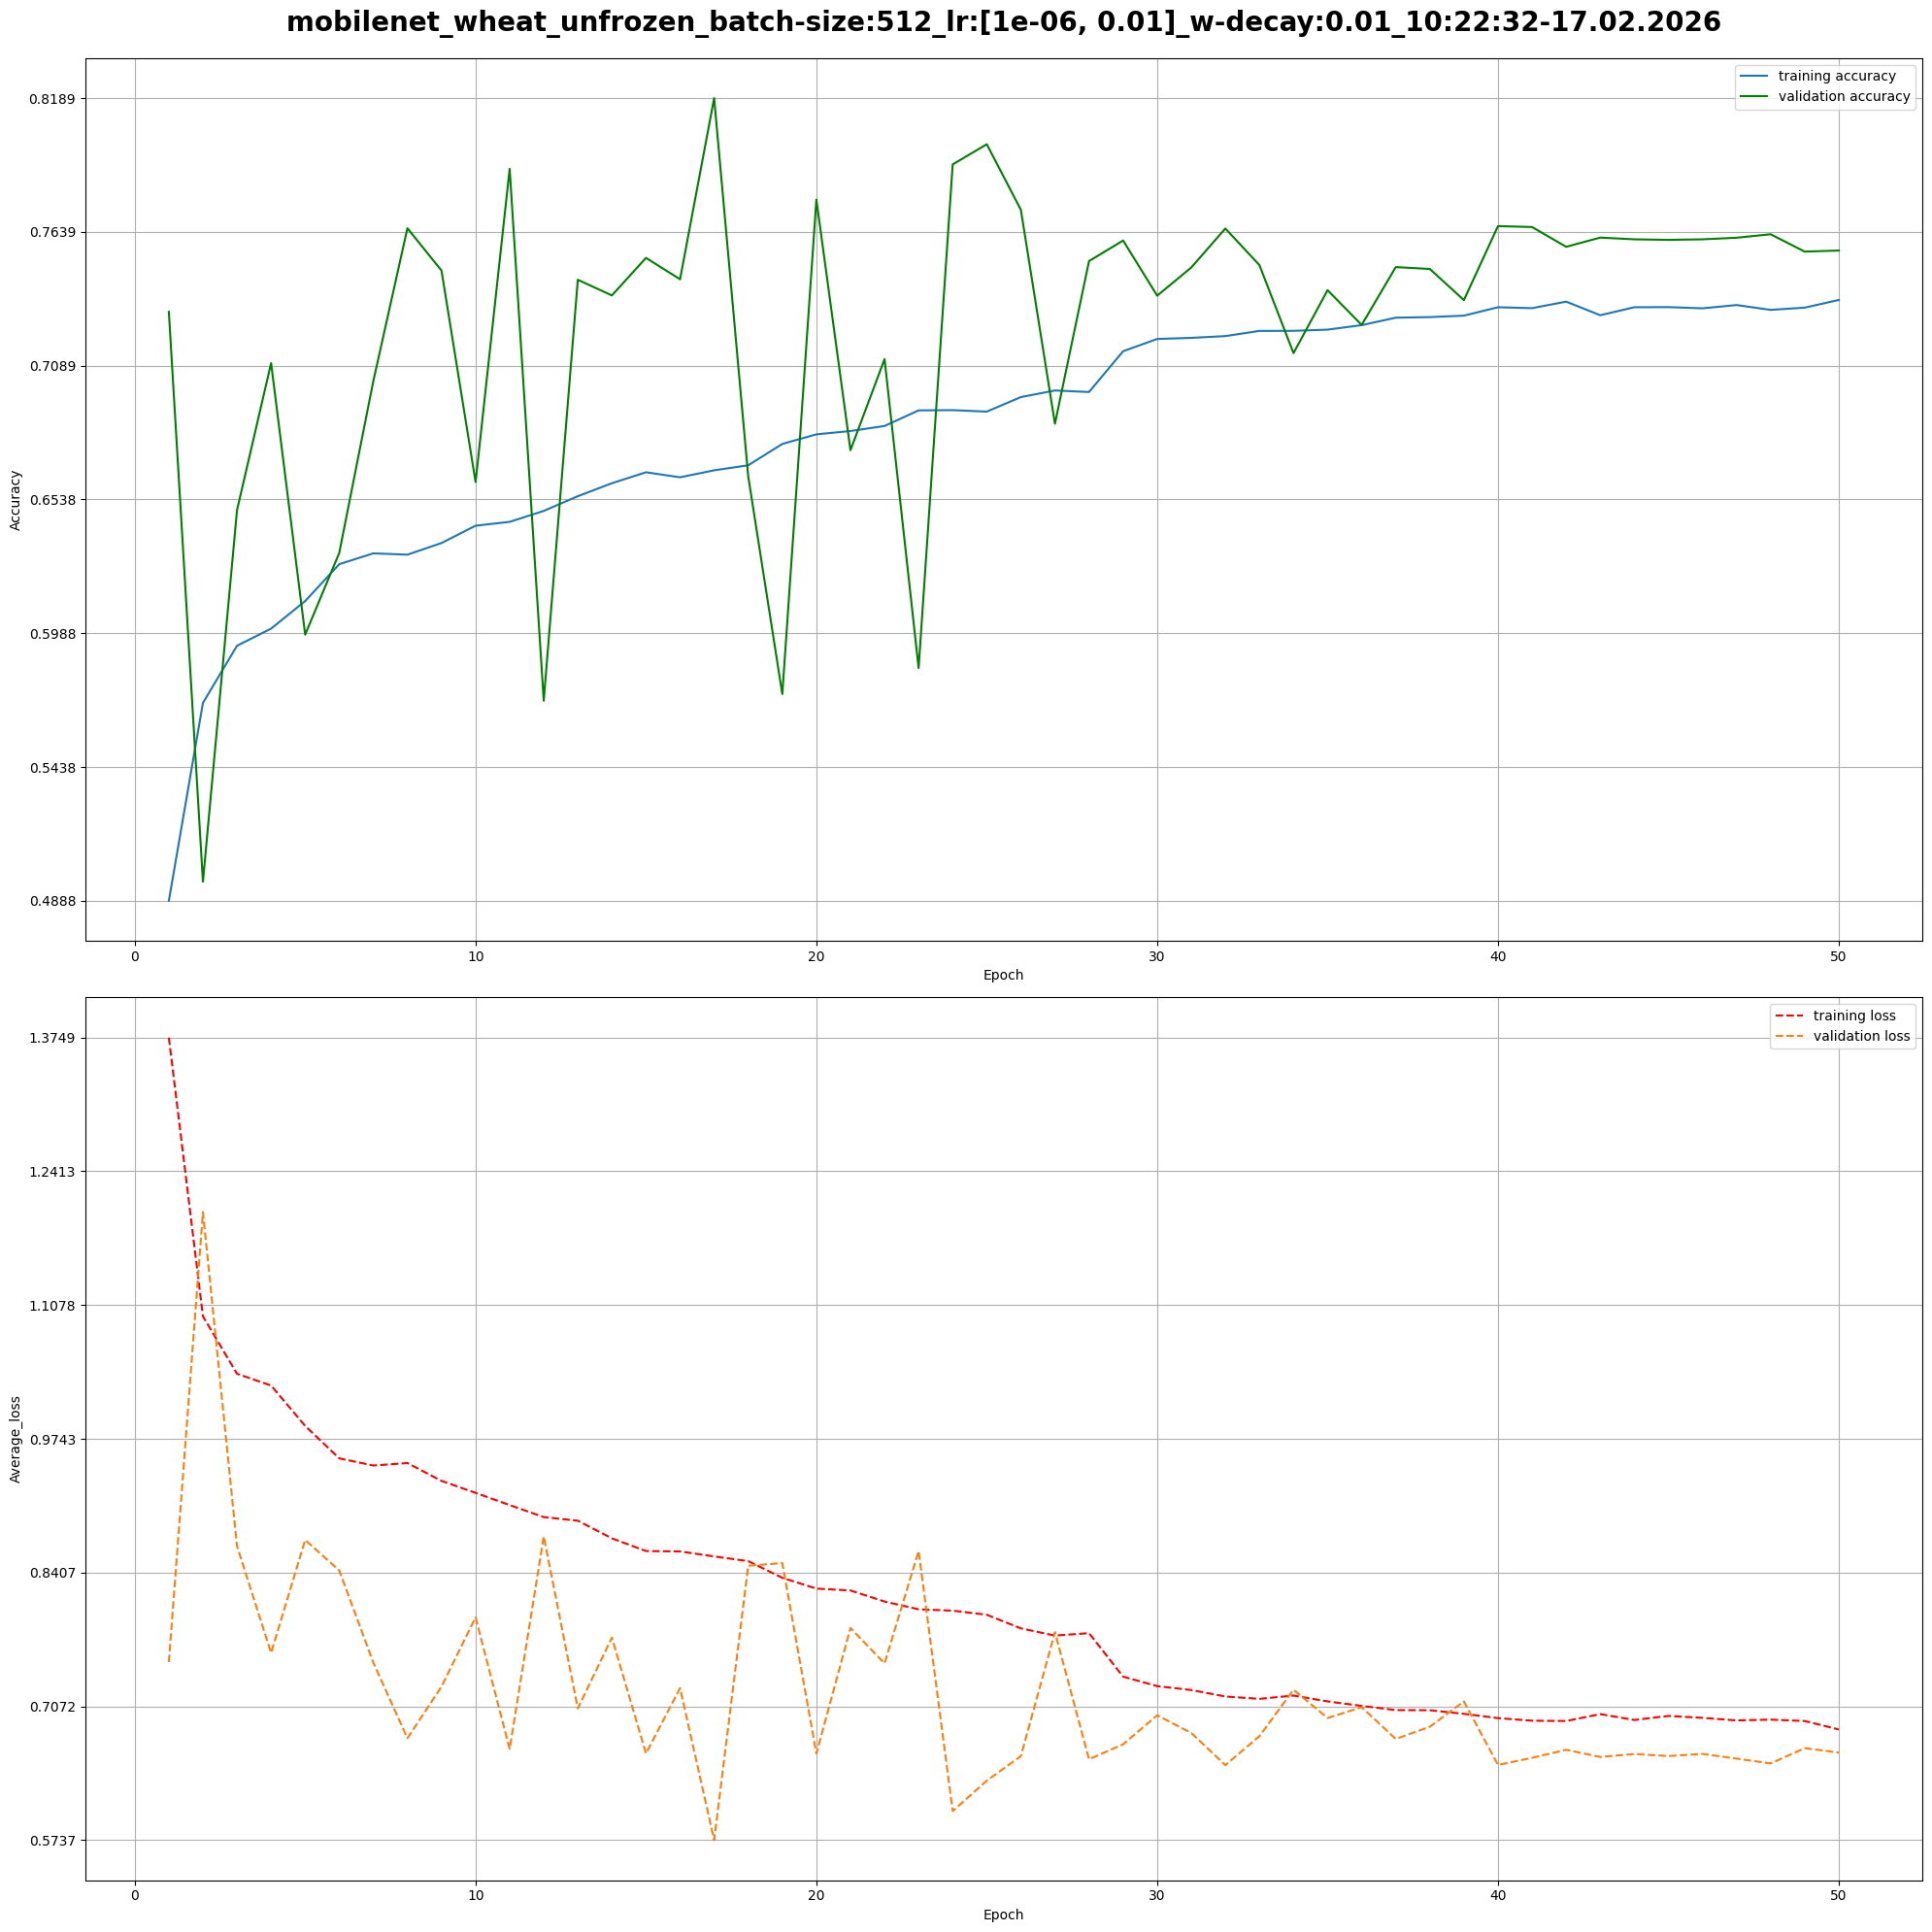

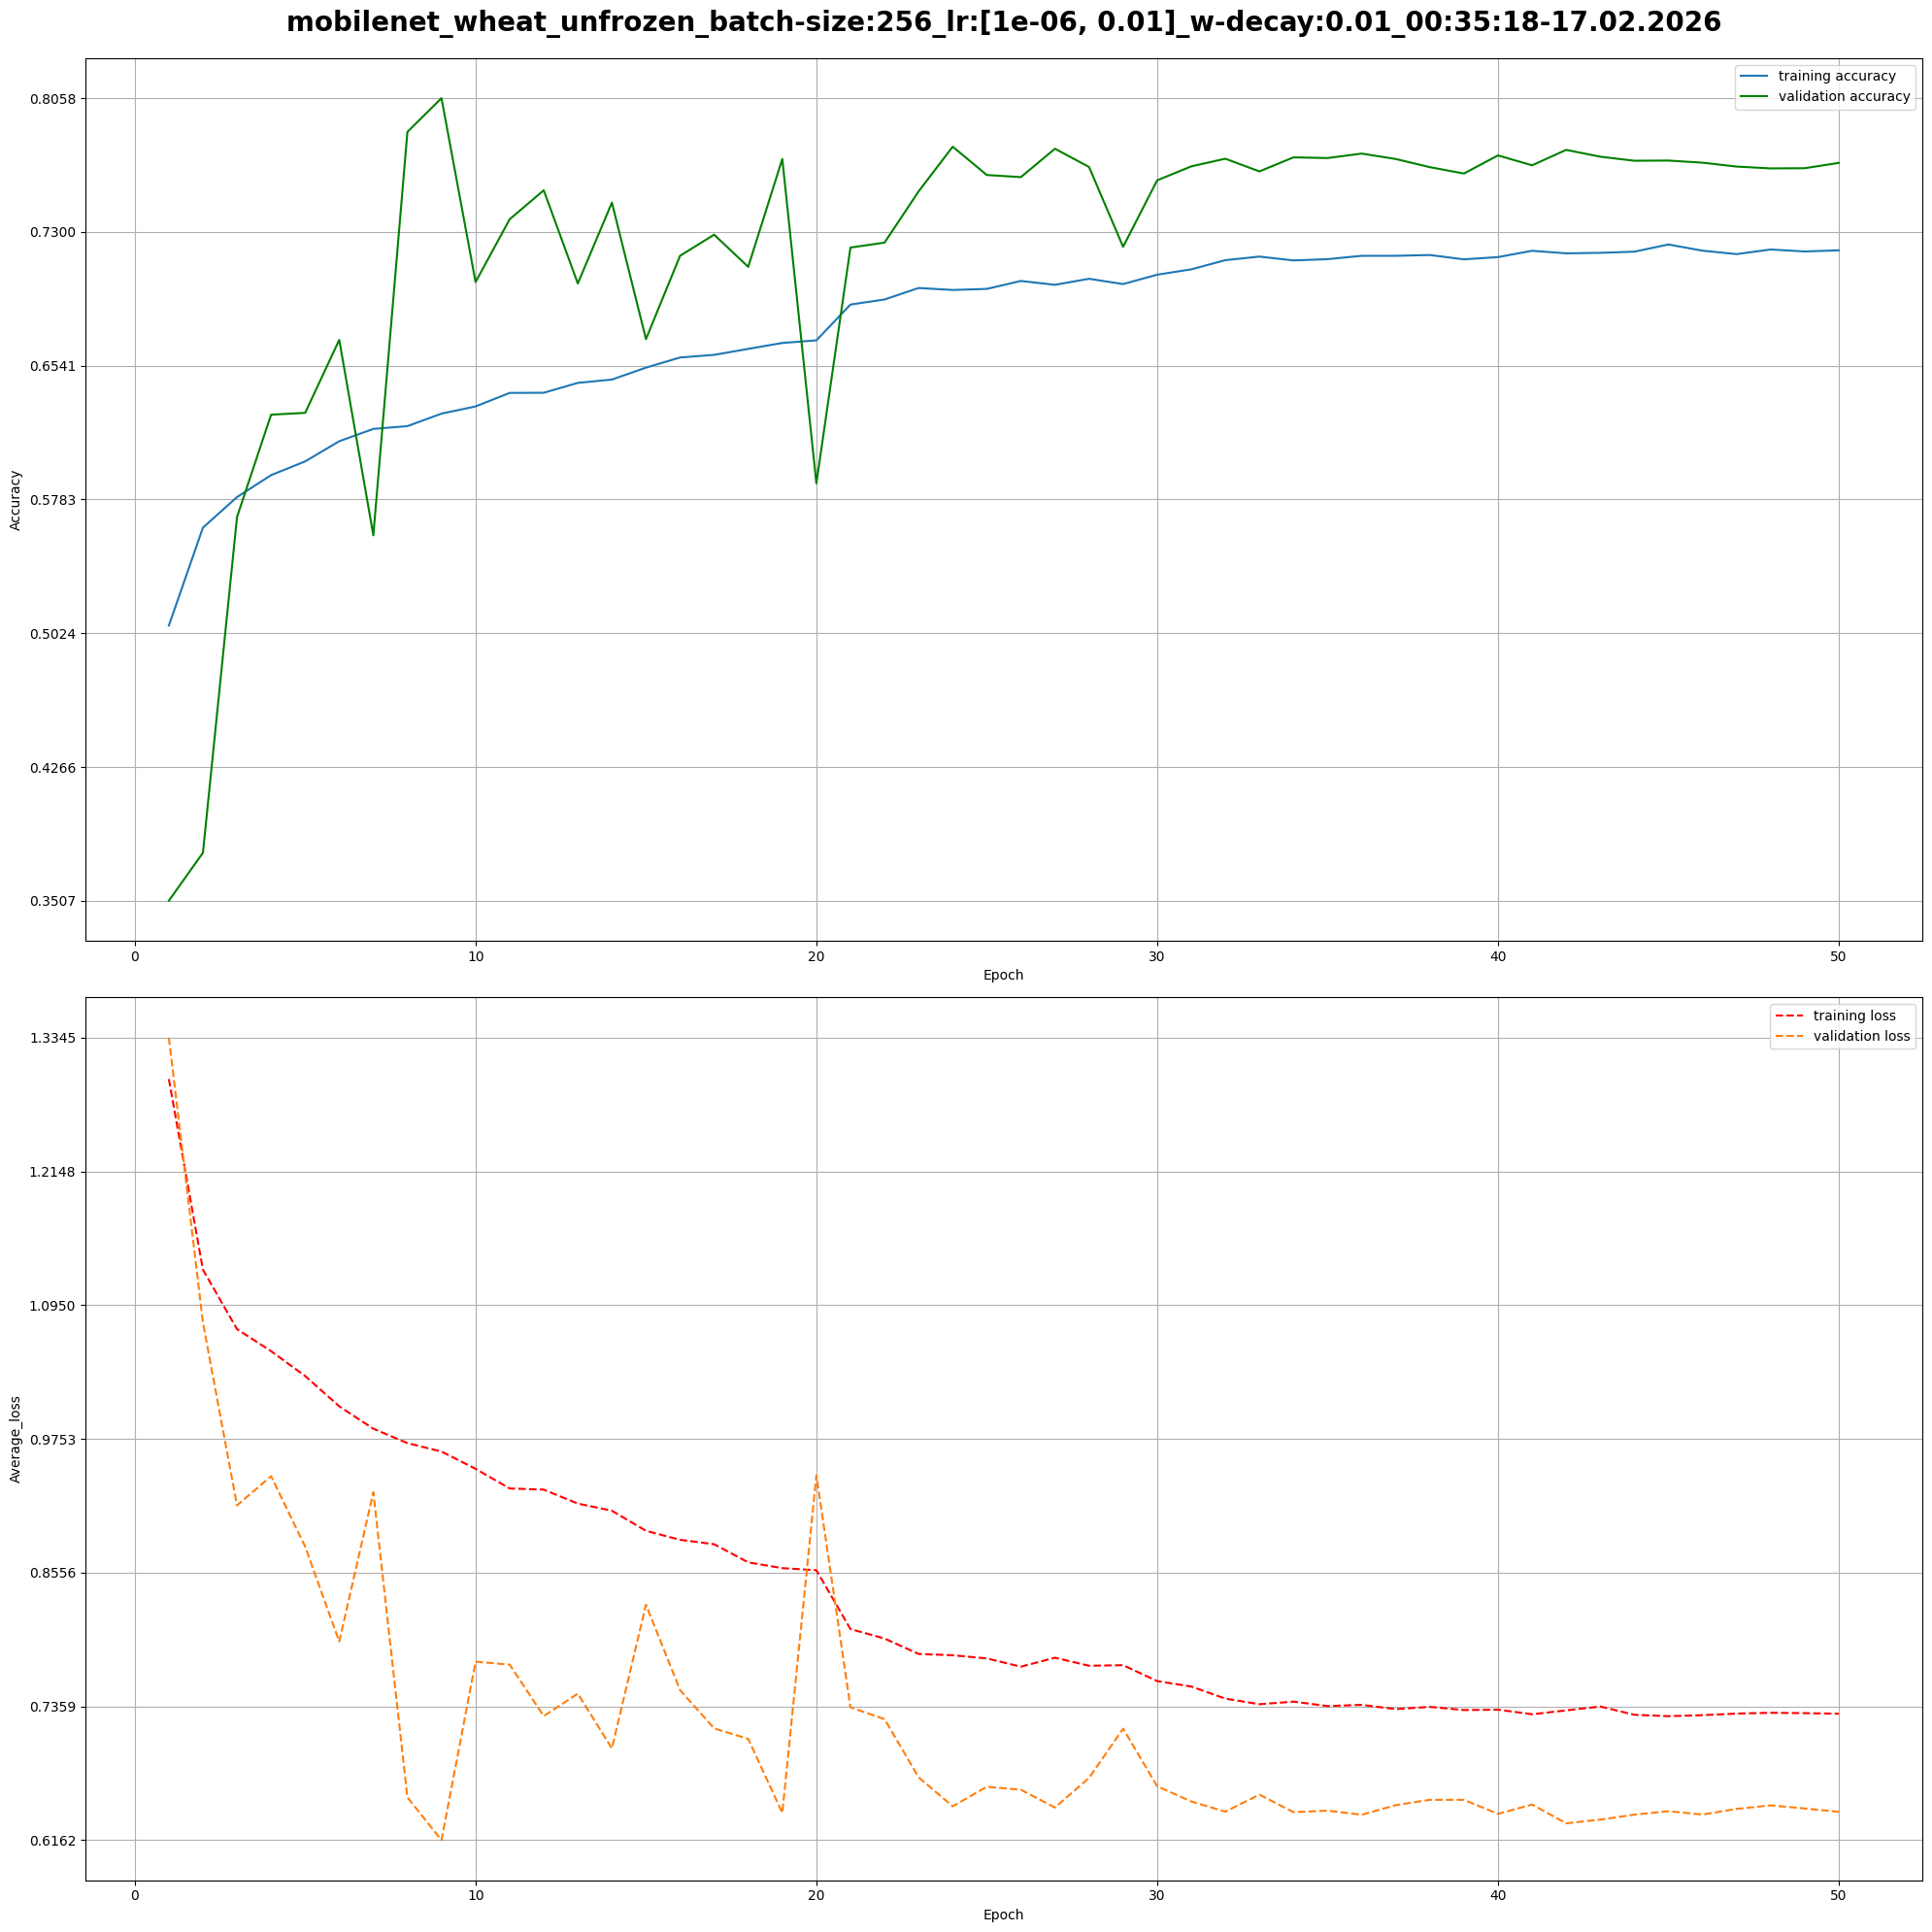

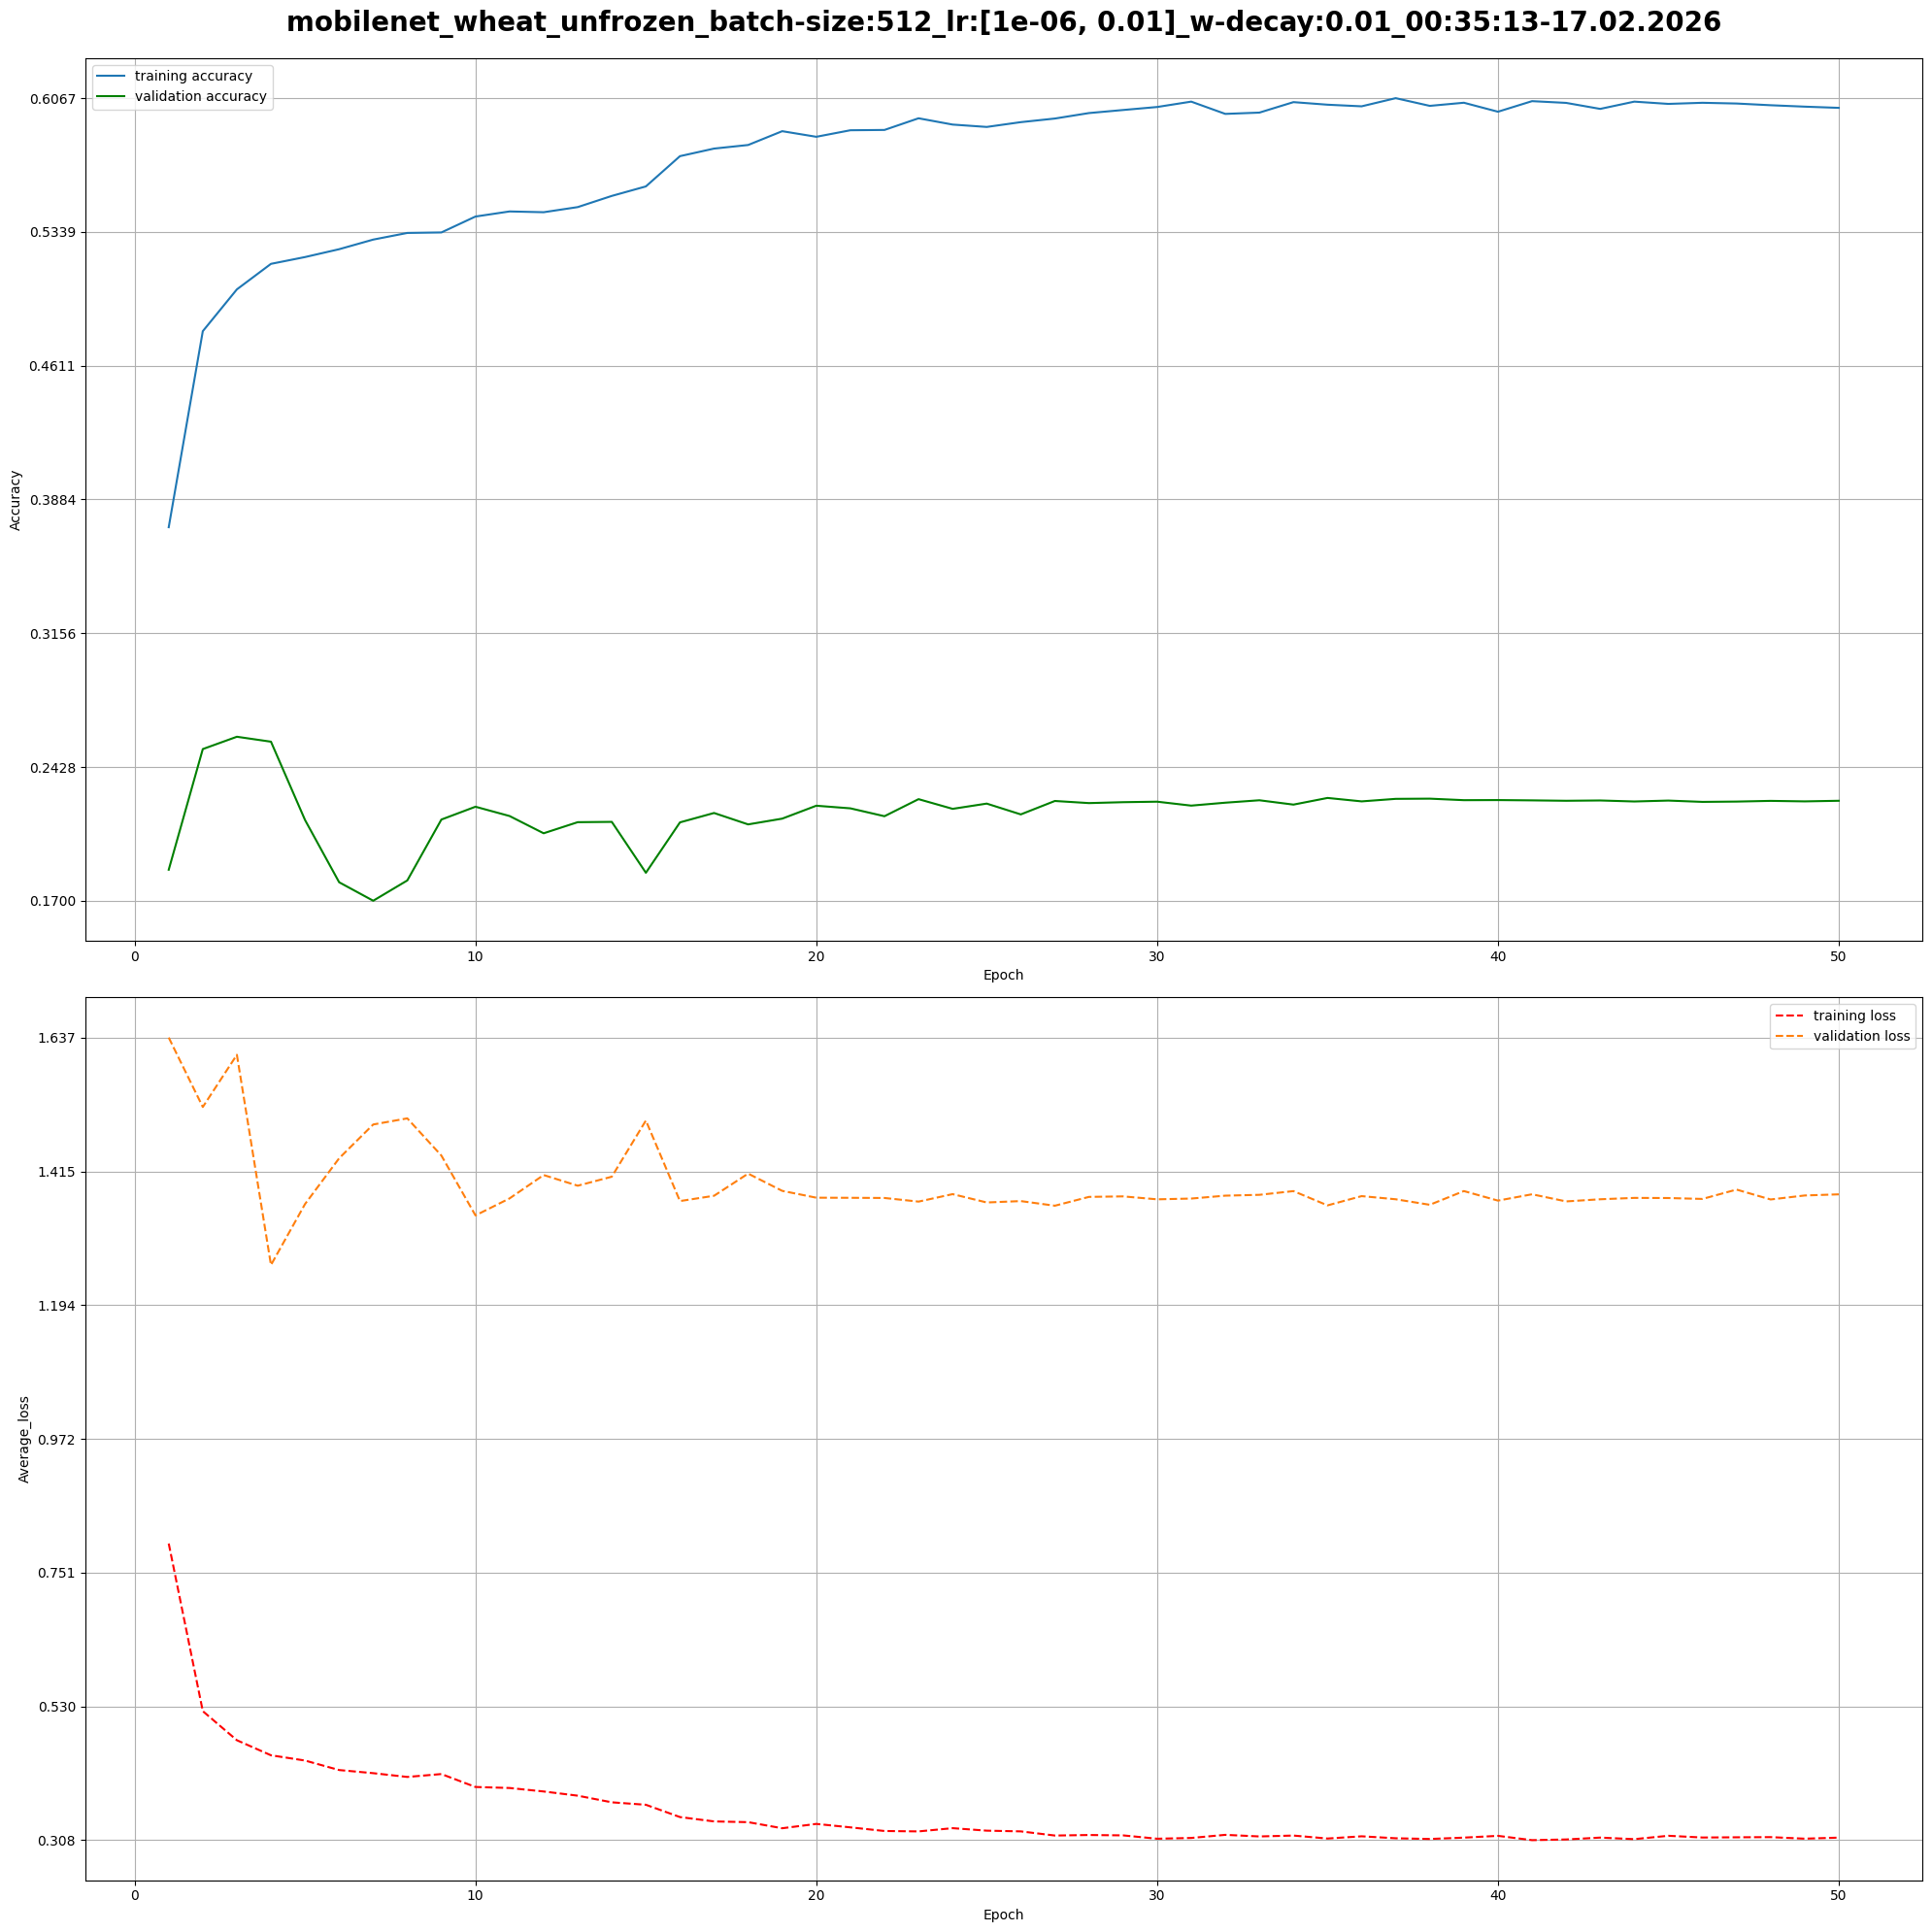

In [4]:
data_folder = "output_data/mobilenet_wheat_unfrozen"
files = csv_dirs(data_folder)
for f in files:
    title = Path(f).name.strip(".csv")
    df = pd.read_csv(f)
    plot_dataframe(df, title)

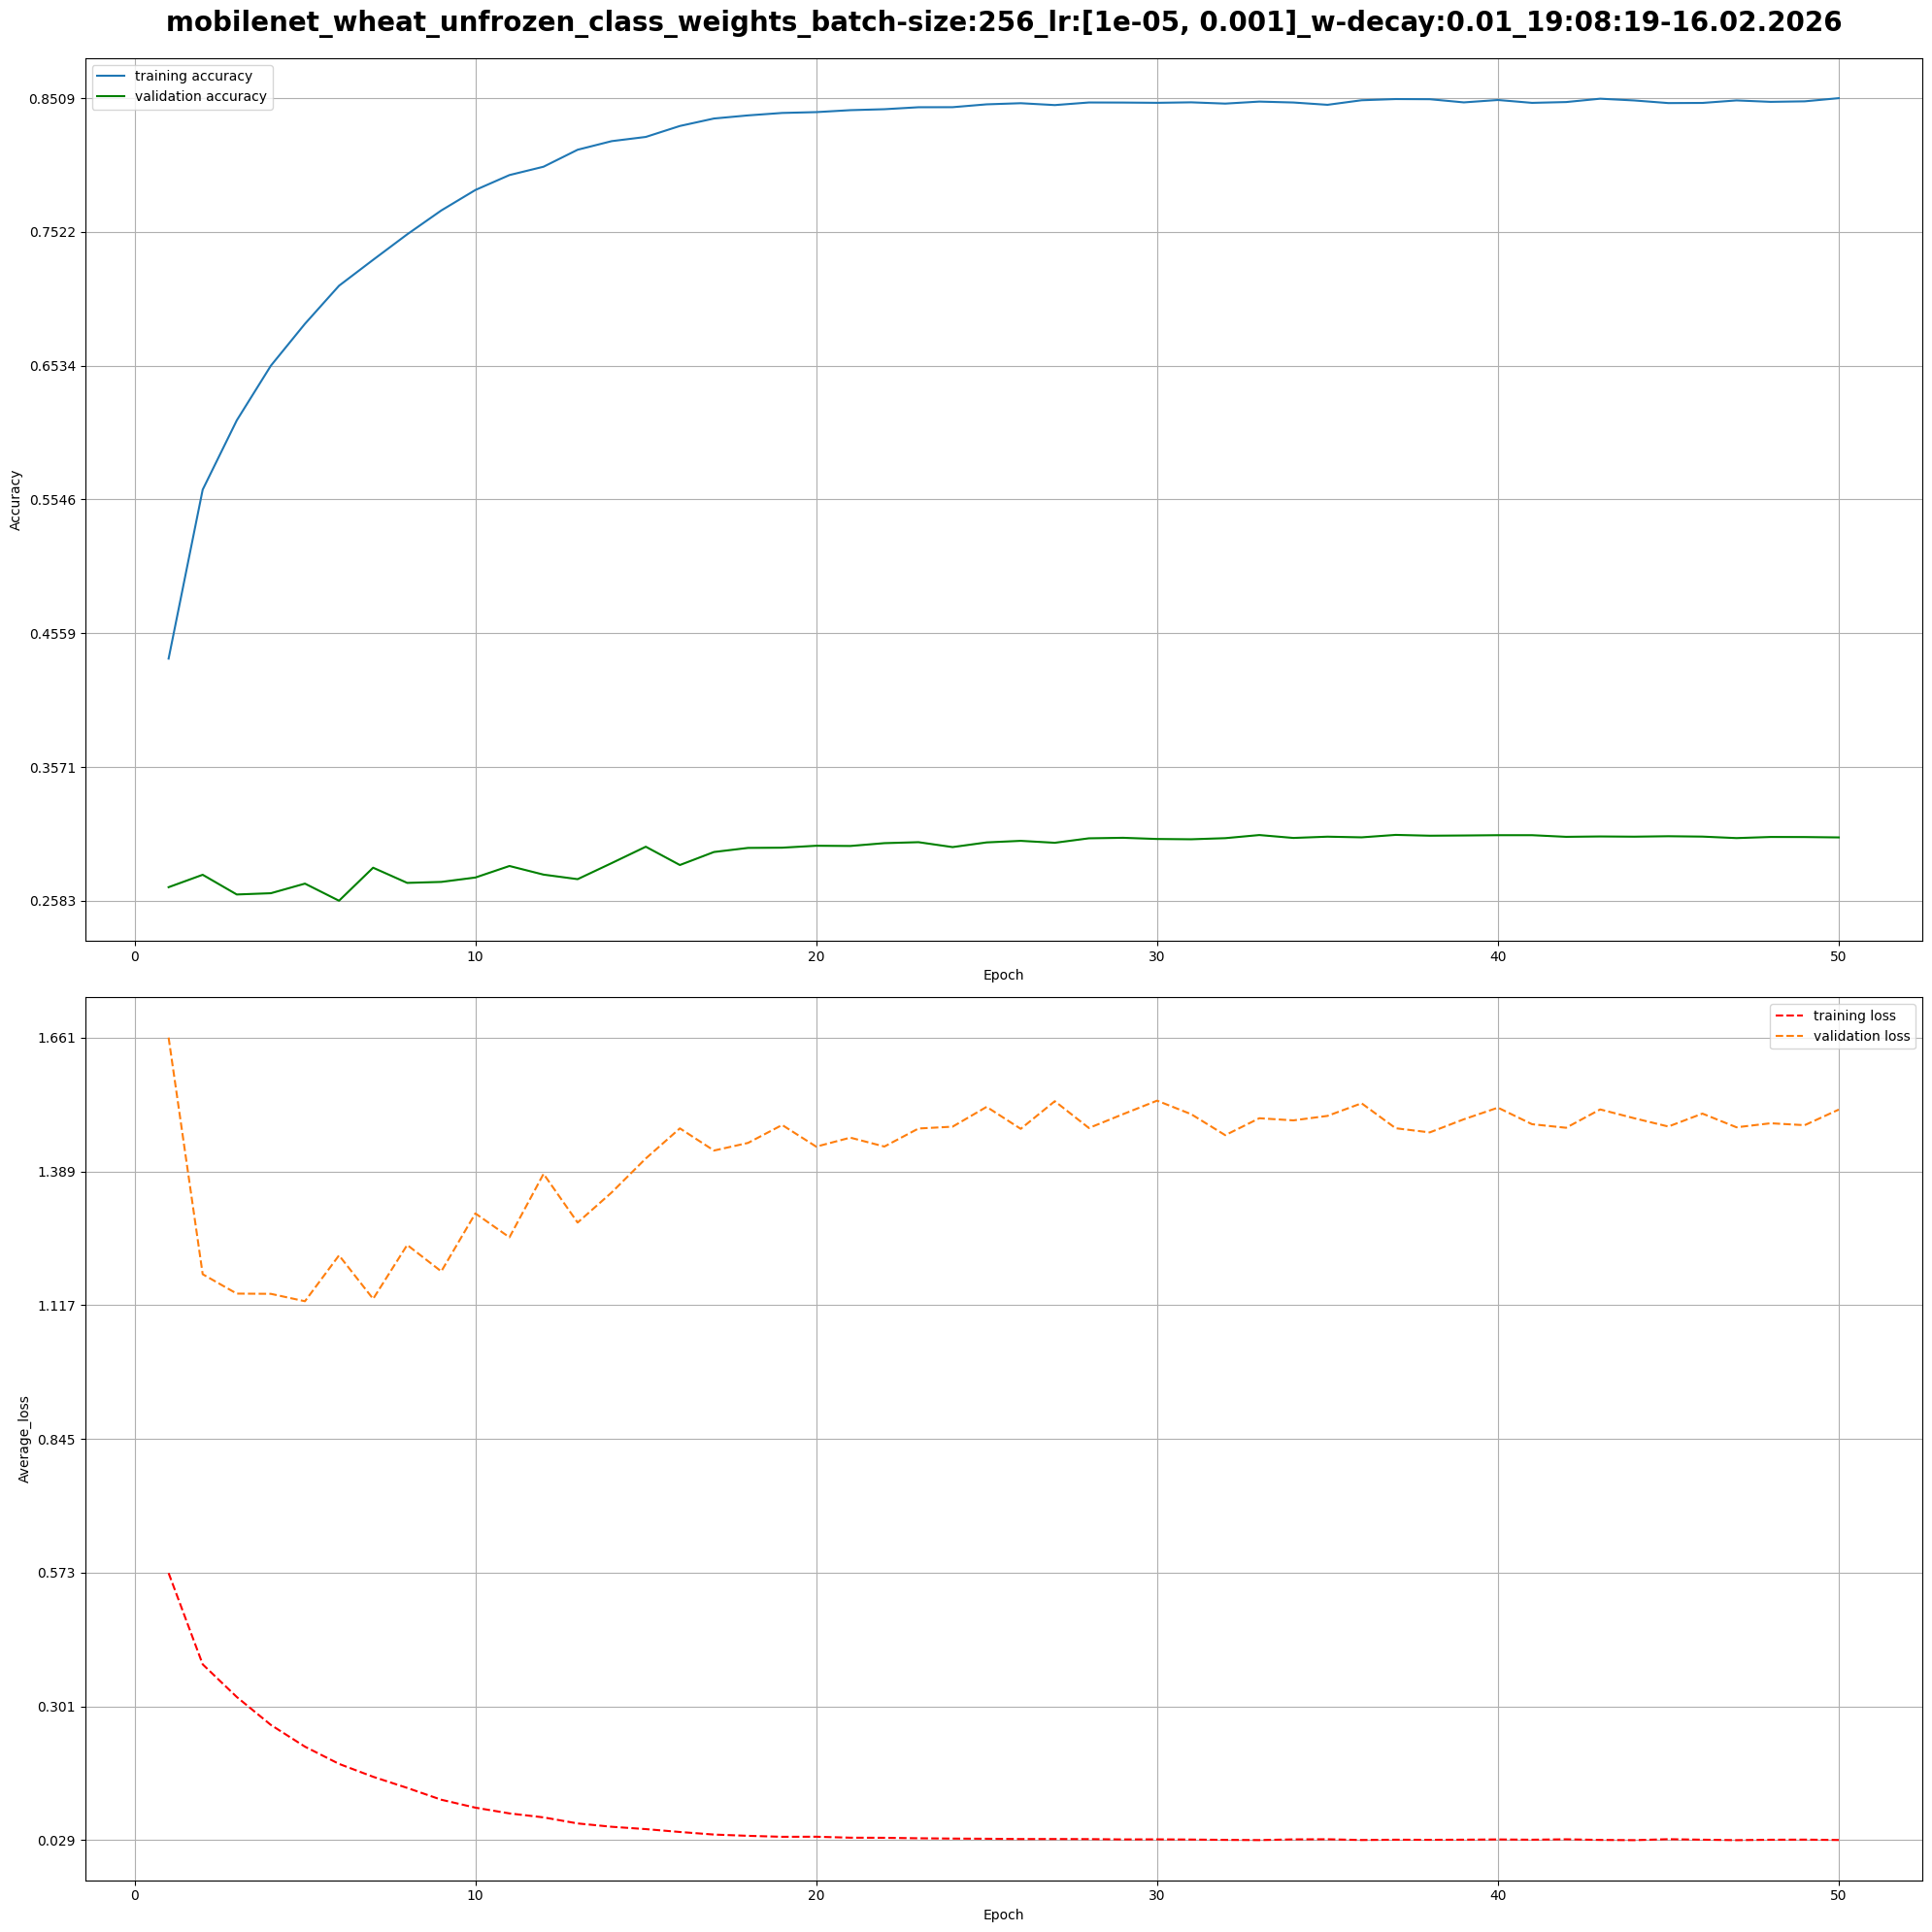

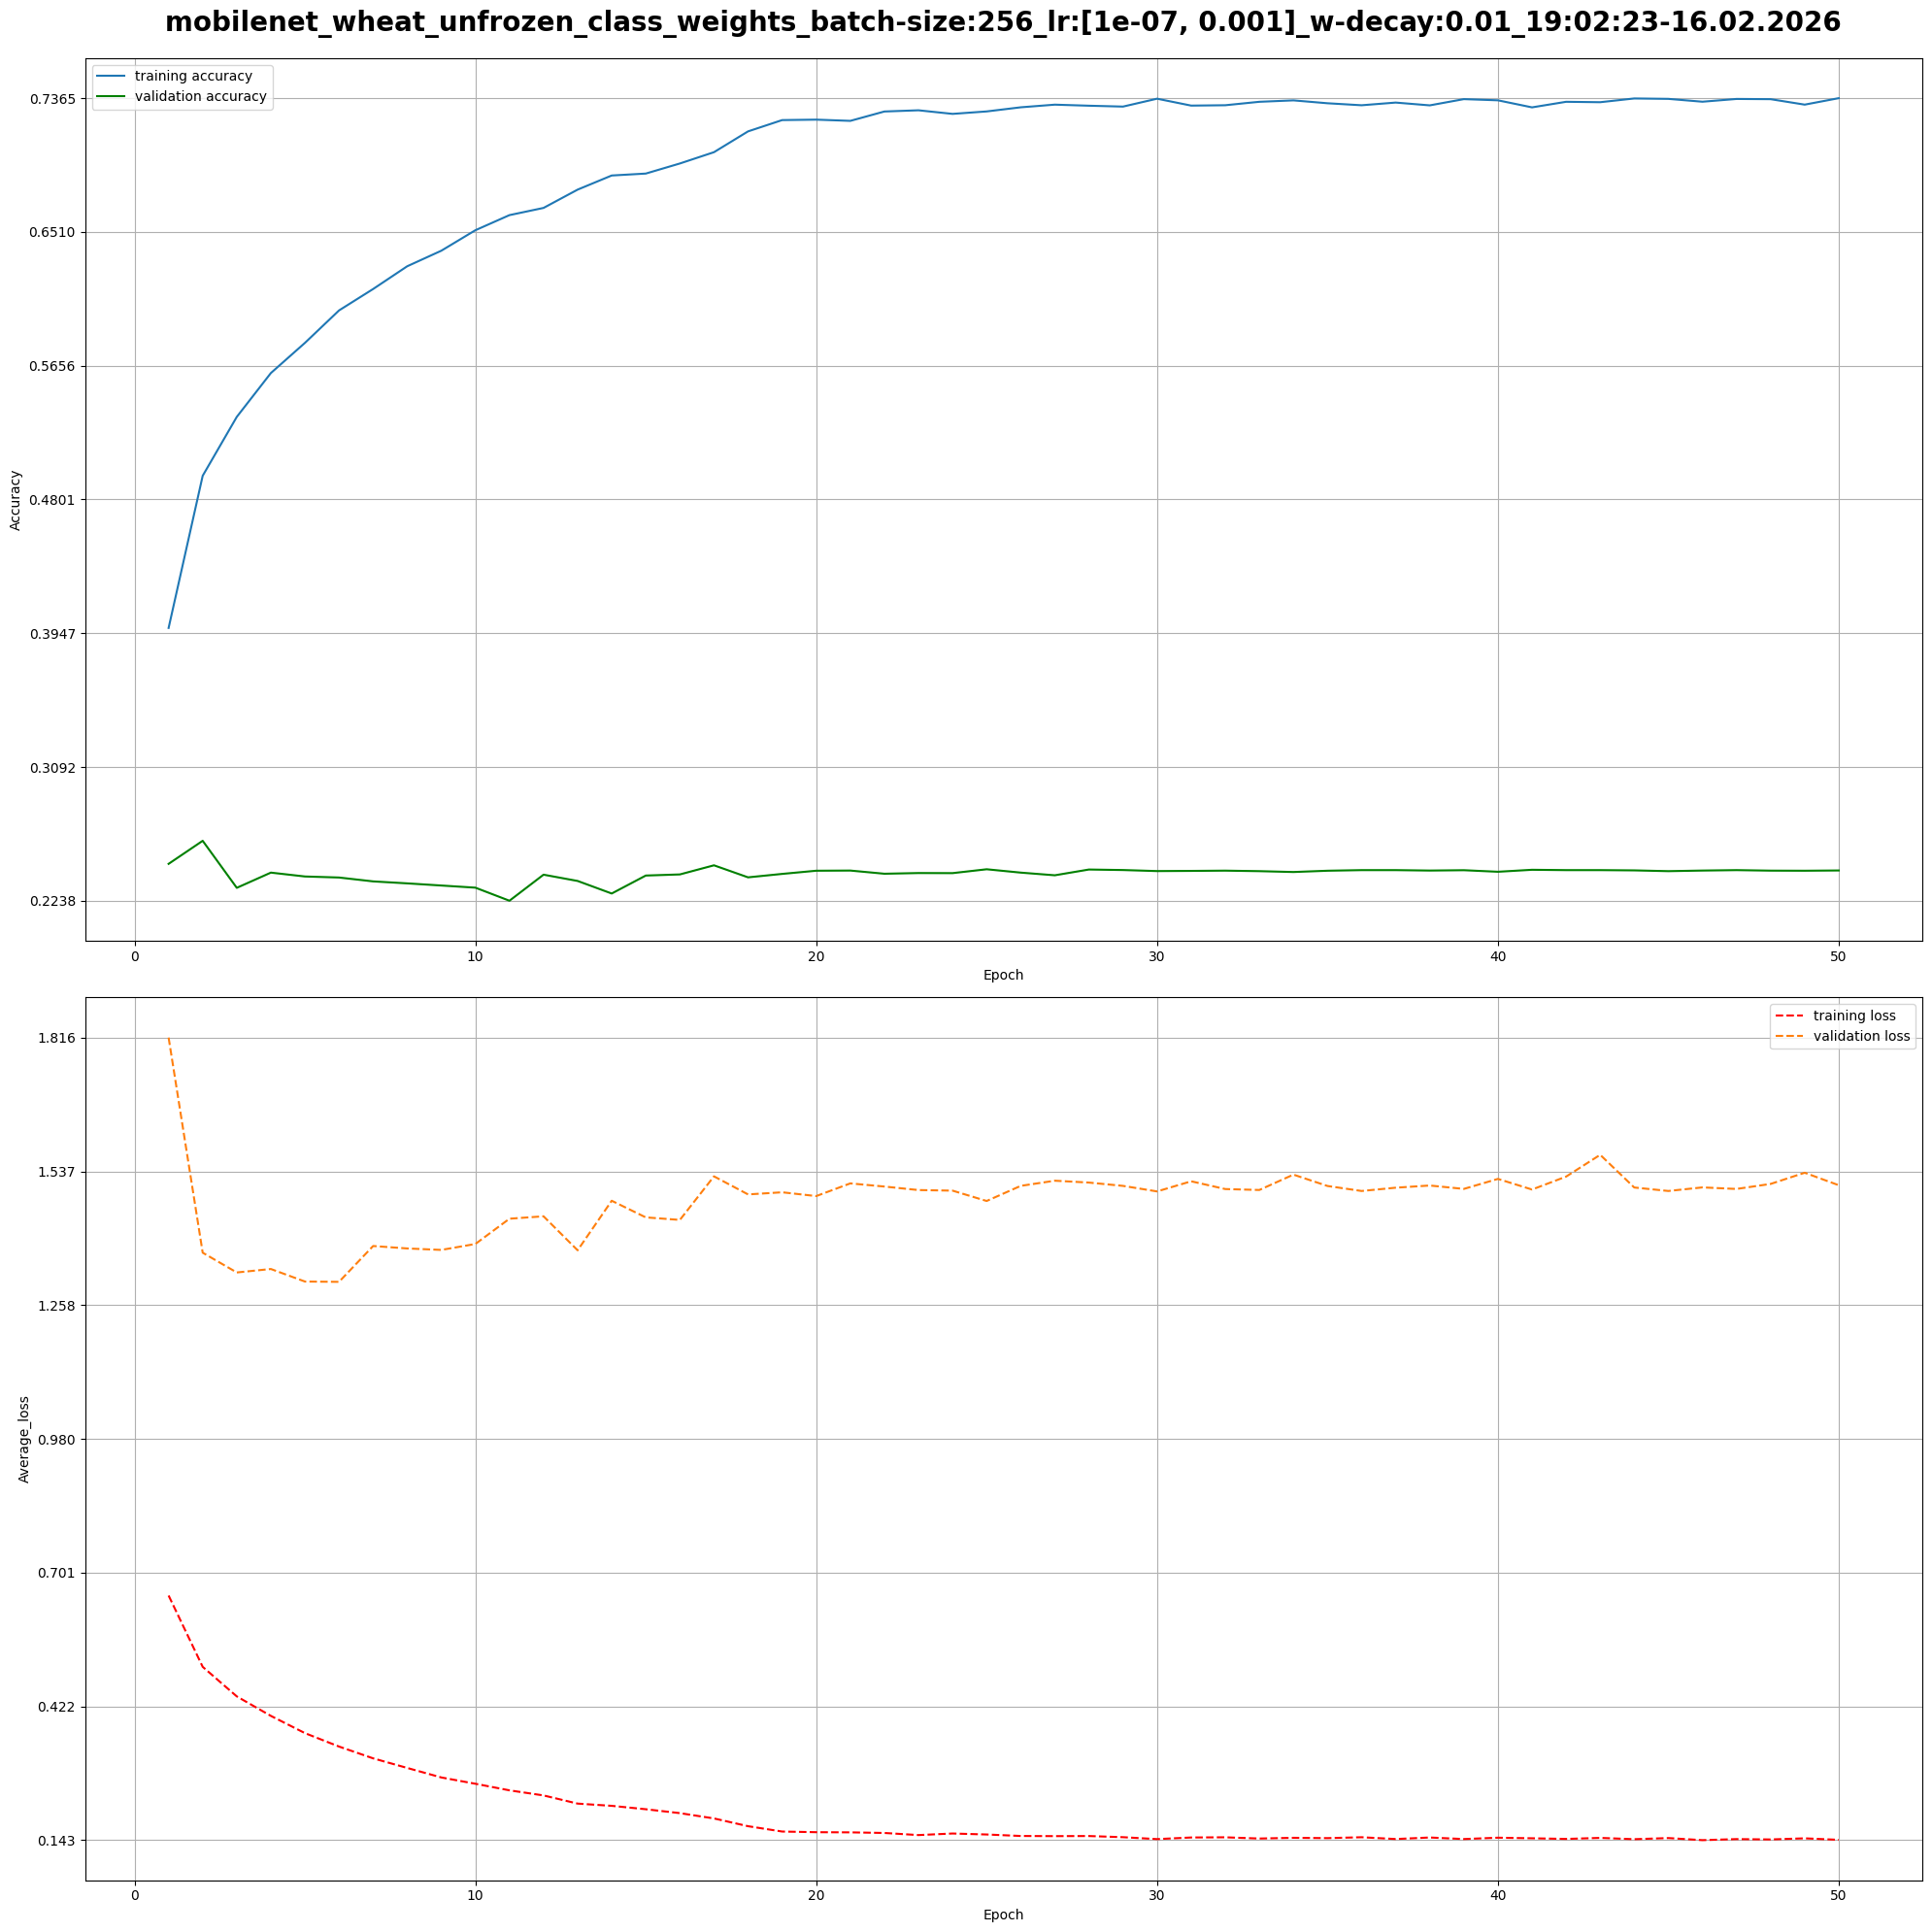

In [3]:
data_folder = "output_data/mobilenet_wheat_unfrozen_class_weights"
files = csv_dirs(data_folder)
for f in files:
    title = Path(f).name.strip(".csv")
    df = pd.read_csv(f)
    plot_dataframe(df, title)

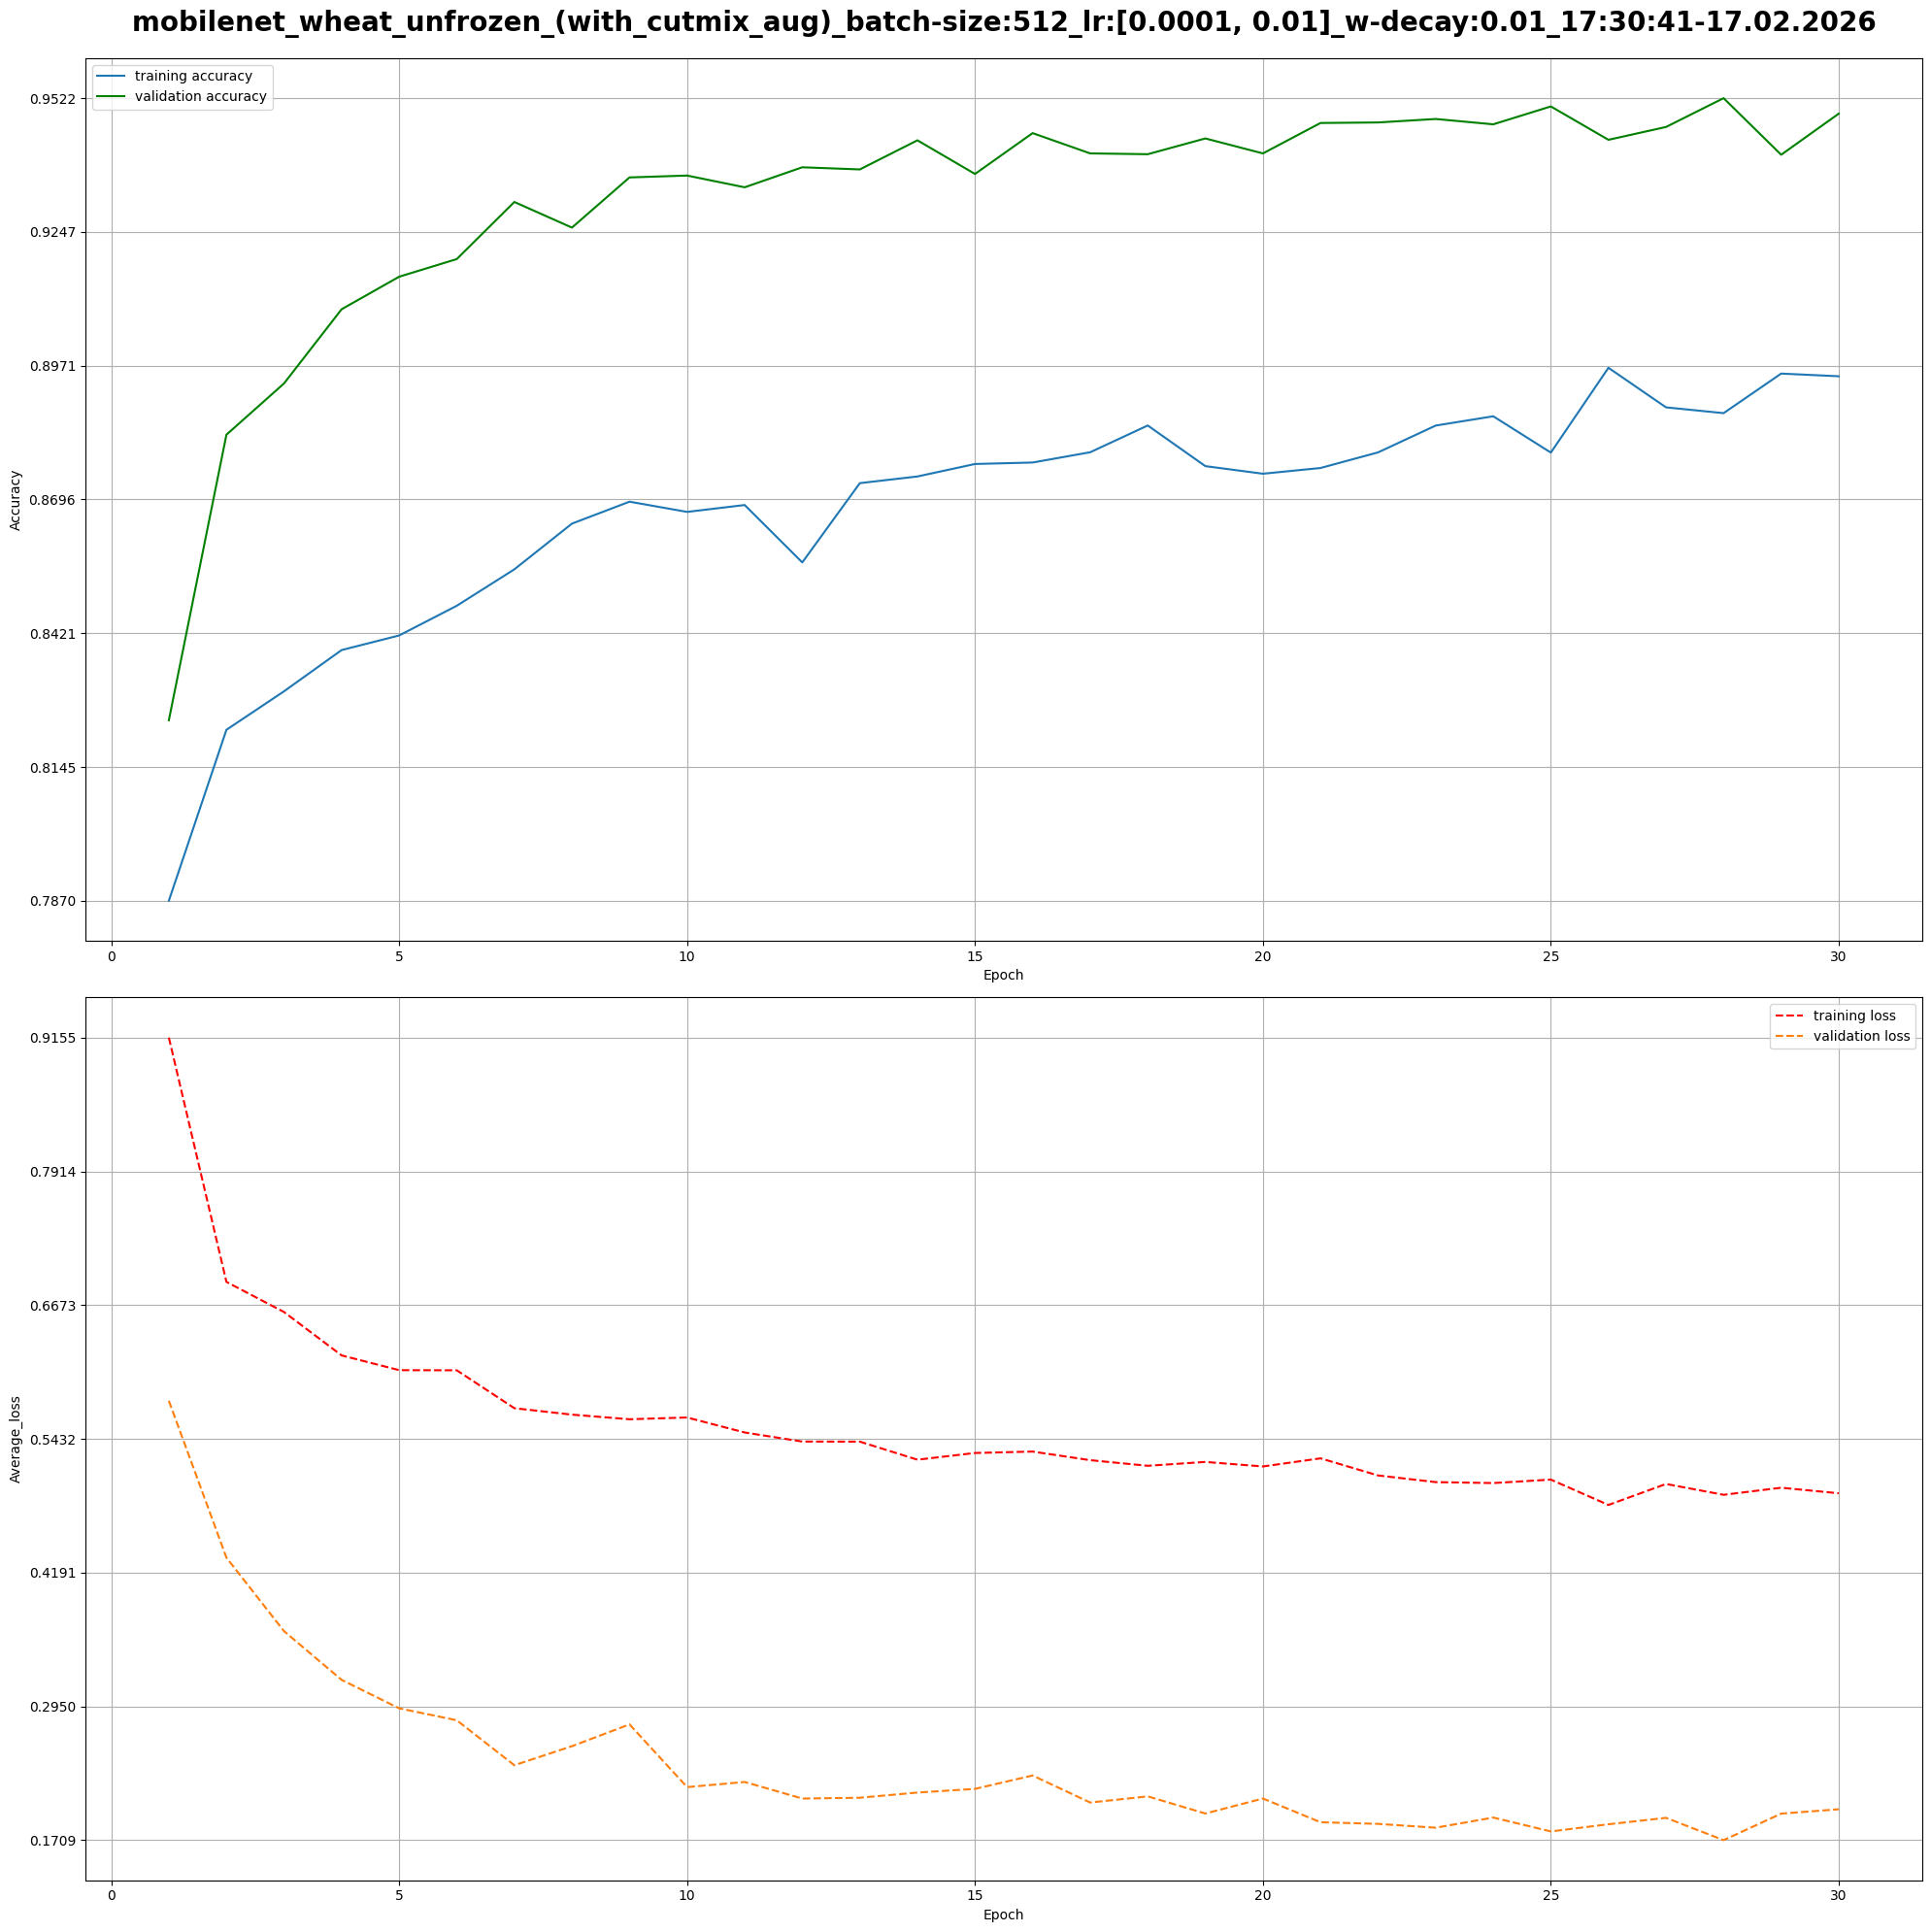

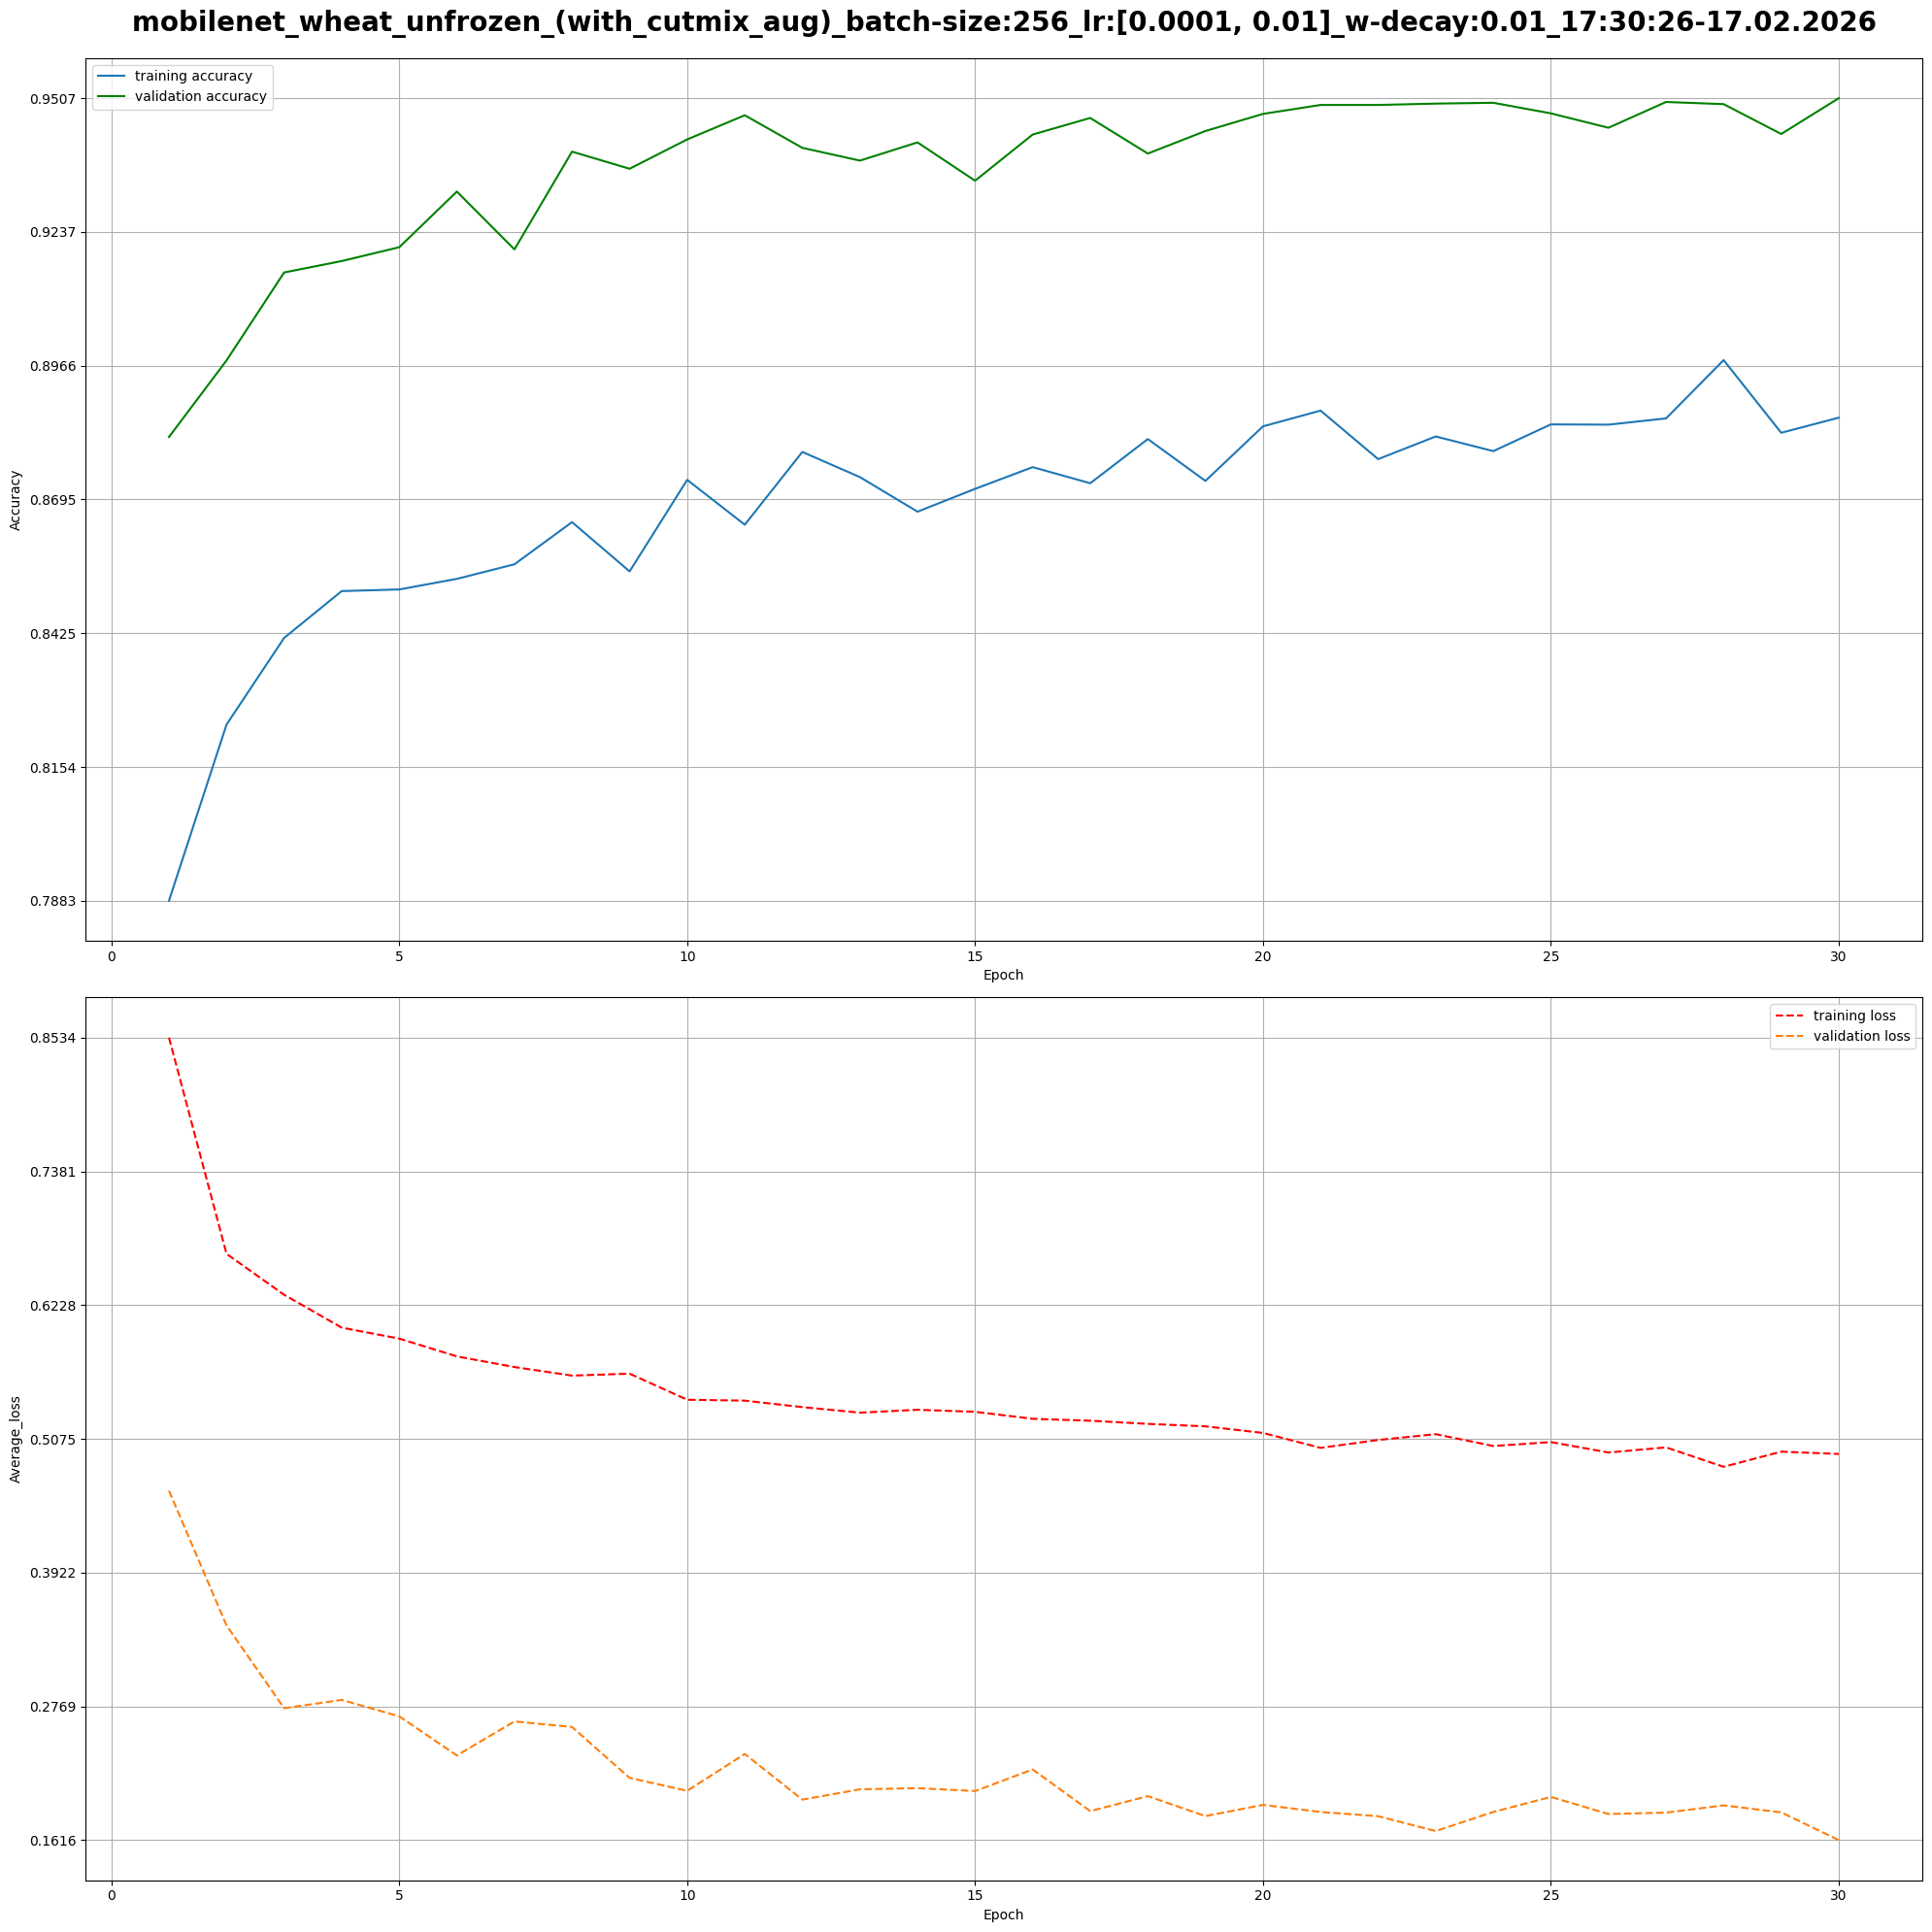

In [6]:
data_folder = "output_data/mobilenet_wheat_unfrozen_(with_cutmix_aug)"
files = csv_dirs(data_folder)
for f in files:
    title = Path(f).name.strip(".csv")
    df = pd.read_csv(f)
    plot_dataframe(df, title)

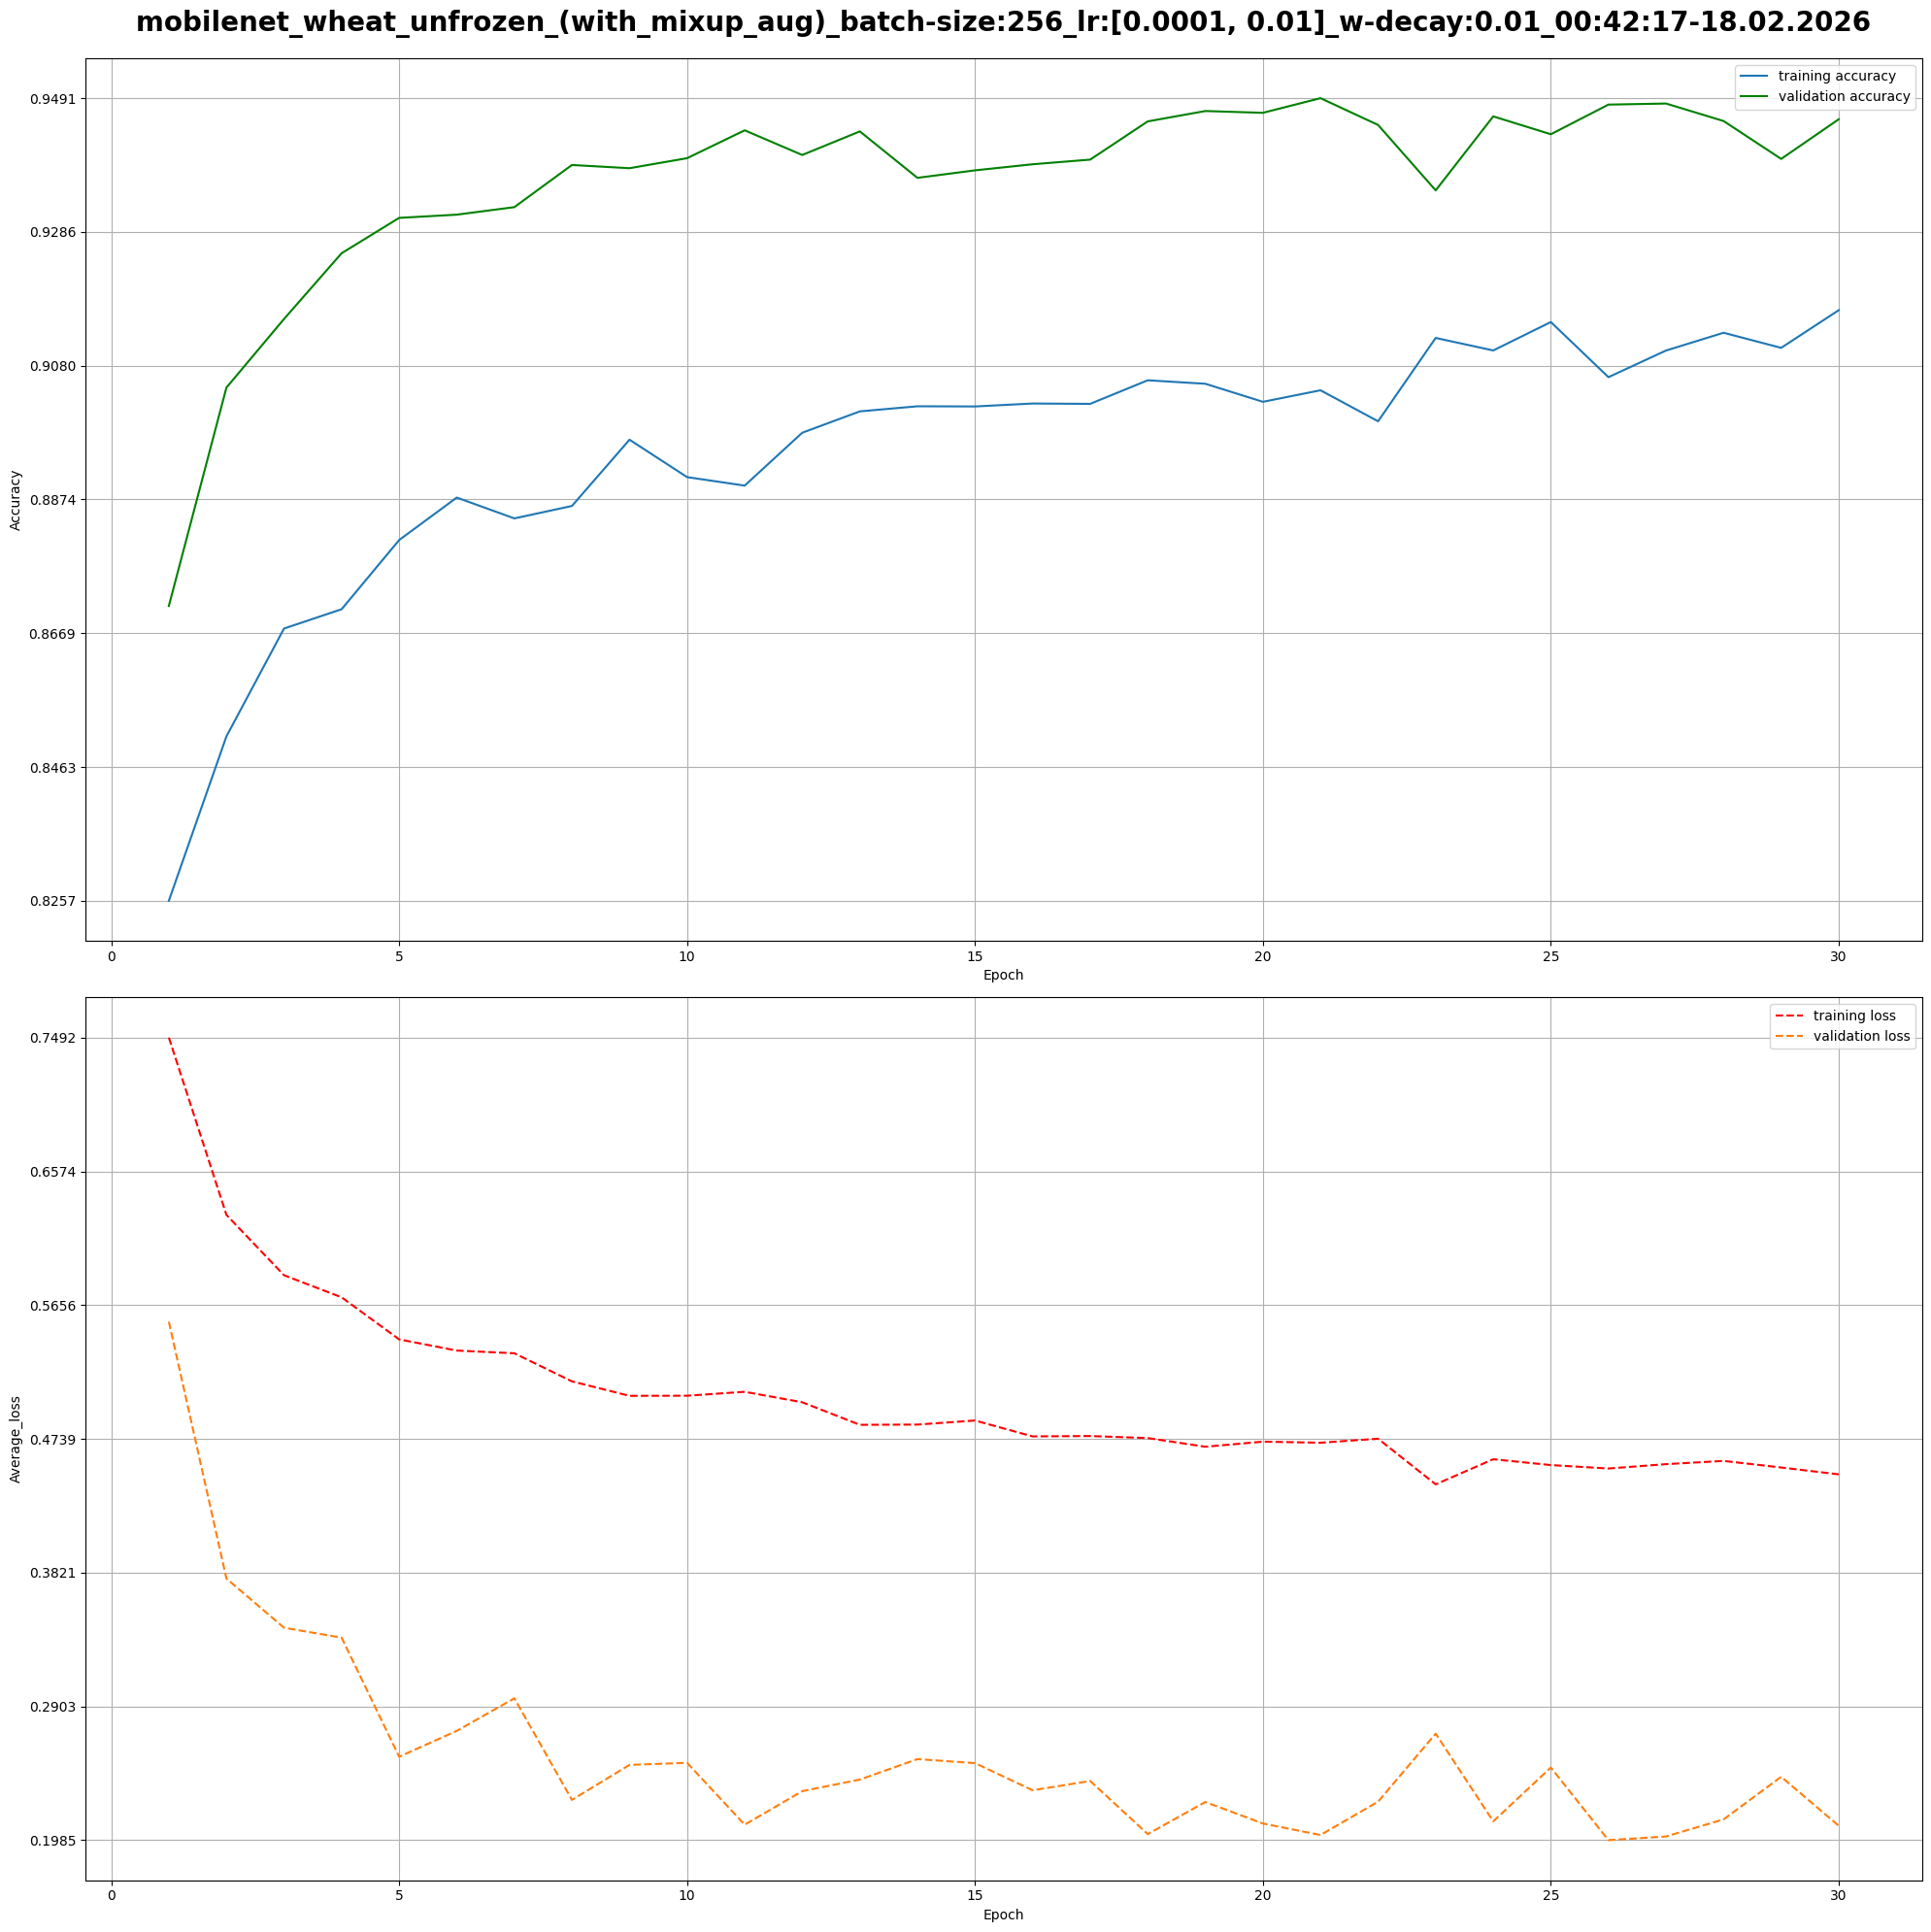

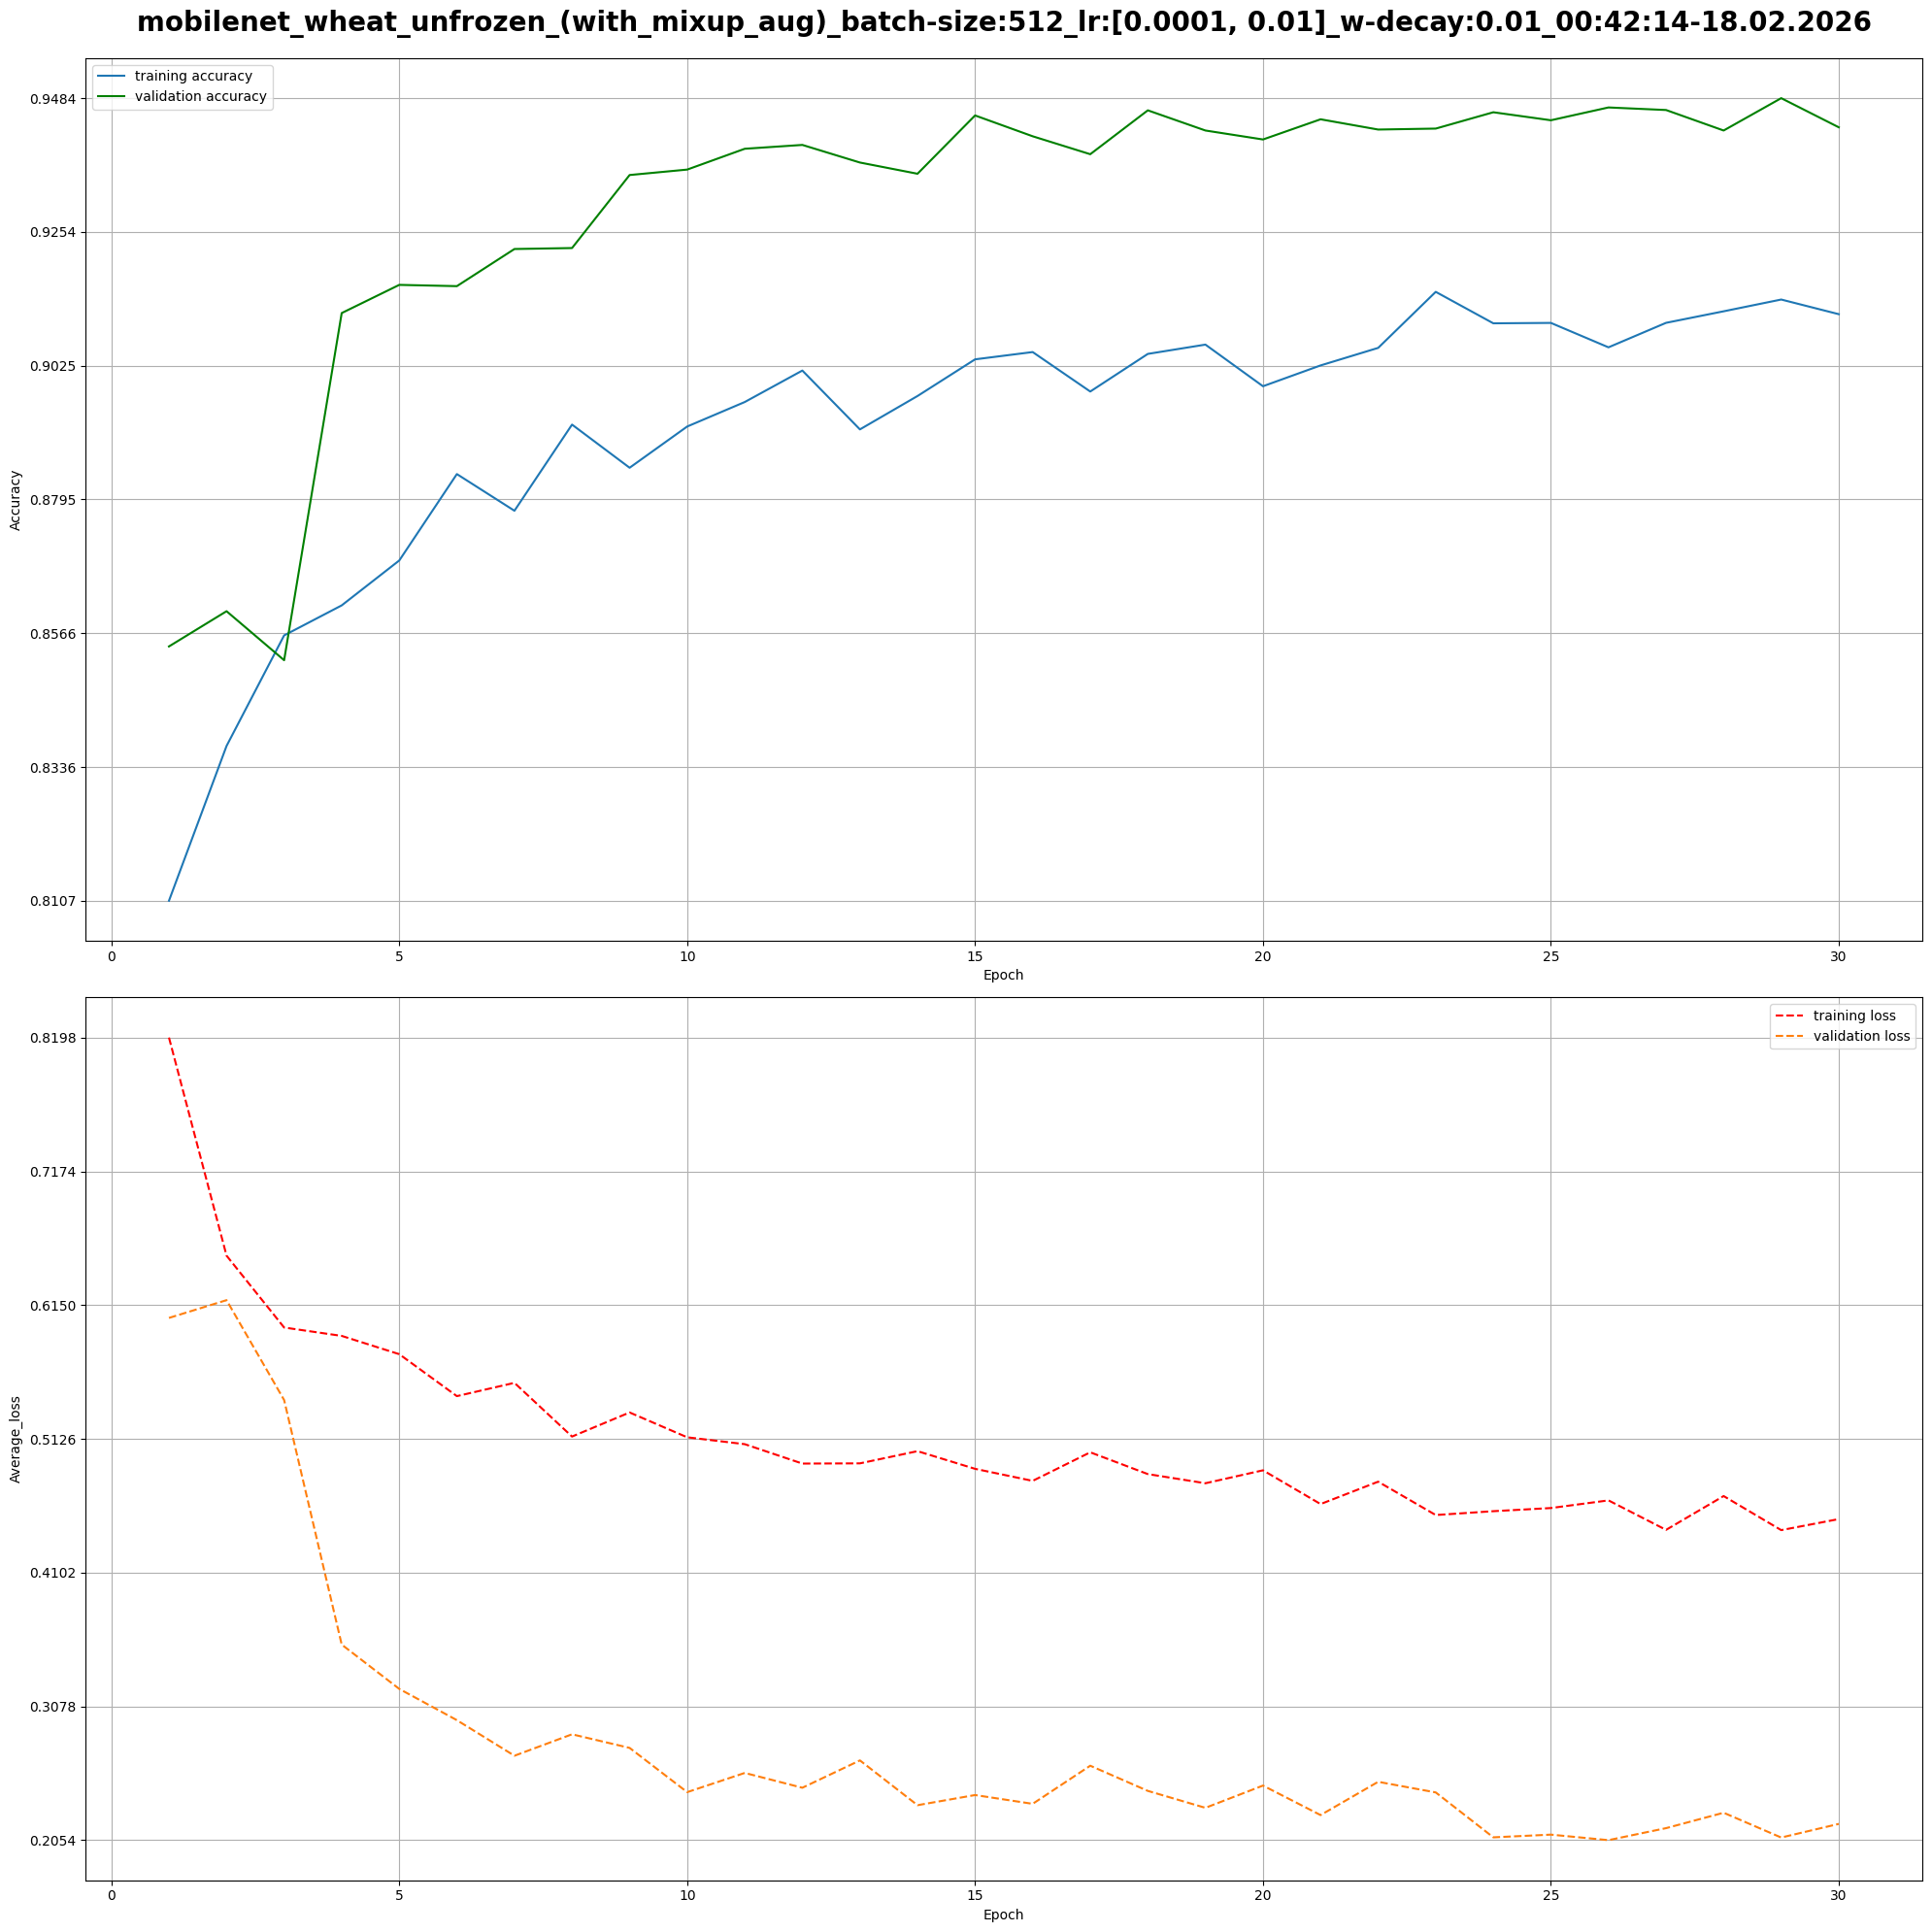

In [7]:
data_folder = "output_data/mobilenet_wheat_unfrozen_(with_mixup_aug)"
files = csv_dirs(data_folder)
for f in files:
    title = Path(f).name.strip(".csv")
    df = pd.read_csv(f)
    plot_dataframe(df, title)

## Confusion Matrices

In [8]:
models_paths = glob.glob('models/*')
cifar_paths = []
wheat_paths = []
for path in models_paths:
    if 'cifar' in path:
        cifar_paths.append(path)
    if 'wheat' in path:
        wheat_paths.append(path)

for p in sorted(cifar_paths):
    print(f"'{p}',")
print('')
for p in sorted(wheat_paths):
    print(f"'{p}',")


'models/mobilenet_wheat_unfrozen_(with_cutmix_aug)_batch-size:256_lr:[0.0001, 0.01]_w-decay:0.01_17:30:26-17.02.2026.pth',
'models/mobilenet_wheat_unfrozen_(with_cutmix_aug)_batch-size:512_lr:[0.0001, 0.01]_w-decay:0.01_17:30:41-17.02.2026.pth',
'models/mobilenet_wheat_unfrozen_(with_mixup_aug)_batch-size:256_lr:[0.0001, 0.01]_w-decay:0.01_00:42:17-18.02.2026.pth',
'models/mobilenet_wheat_unfrozen_(with_mixup_aug)_batch-size:512_lr:[0.0001, 0.01]_w-decay:0.01_00:42:14-18.02.2026.pth',
'models/mobilenet_wheat_unfrozen_batch-size:256_lr:[0.0001, 0.01]_w-decay:0.01_12:55:29-17.02.2026.pth',
'models/mobilenet_wheat_unfrozen_batch-size:256_lr:[1e-05, 0.01]_w-decay:0.01_21:34:01-16.02.2026.pth',
'models/mobilenet_wheat_unfrozen_batch-size:256_lr:[1e-06, 0.01]_w-decay:0.01_00:35:18-17.02.2026.pth',
'models/mobilenet_wheat_unfrozen_batch-size:256_lr:[1e-07, 0.001]_w-decay:0.01_13:04:18-16.02.2026.pth',
'models/mobilenet_wheat_unfrozen_batch-size:256_lr:[1e-07, 0.001]_w-decay:0.01_15:53:25-16.

In [ ]:
# from cifar_data_prep import TESTING_DATA as cifar_data, CLASSES as cifar_classes, data_loader as cifar_loader

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # cifar_paths = []
# cifar_cm_data = []
# for path in cifar_paths:
#     print(path)
#     print(get_batch_size(path))
#     test_loader = cifar_loader(cifar_data, device, batch_size=get_batch_size(path))
#     cifar_trues, cifar_preds = perform_eval(path,cifar_classes,test_loader)
#     cifar_cm_data.append((path, cifar_trues, cifar_preds))
#     cifar_title = path.strip("models/").strip(".pth")
#     confusion_matrix(cifar_title, cifar_trues, cifar_preds, cifar_classes)

models/mobilenet_wheat_unfrozen_(with_cutmix_aug)_batch-size:256_lr:[0.0001, 0.01]_w-decay:0.01_17:30:26-17.02.2026.pth
batch size:  256
Accuracy of the network on the 10000 test images: 89 %
Accuracy for class: Black germ is 76.6 %
Accuracy for class: Broken is 98.6 %
Accuracy for class: Fusarium is 78.5 %
Accuracy for class: Insect is 47.7 %
Accuracy for class: Moldy is 45.6 %
Accuracy for class: Sound is 99.2 %
Accuracy for class: Spotted is 76.2 %
Accuracy for class: Sprouted is 77.6 %


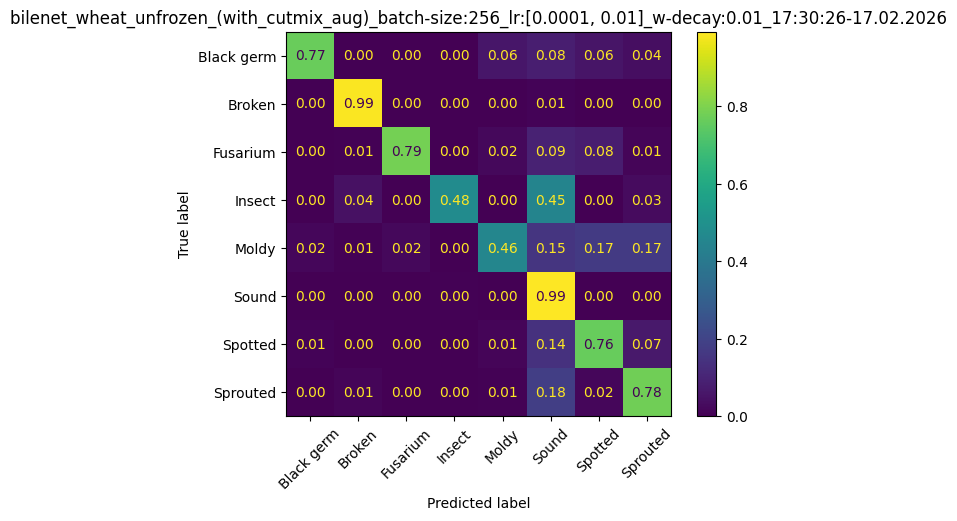

models/mobilenet_wheat_unfrozen_(with_cutmix_aug)_batch-size:512_lr:[0.0001, 0.01]_w-decay:0.01_17:30:41-17.02.2026.pth
batch size:  512
Accuracy of the network on the 10000 test images: 90 %
Accuracy for class: Black germ is 84.8 %
Accuracy for class: Broken is 99.3 %
Accuracy for class: Fusarium is 80.1 %
Accuracy for class: Insect is 48.4 %
Accuracy for class: Moldy is 72.5 %
Accuracy for class: Sound is 97.4 %
Accuracy for class: Spotted is 82.3 %
Accuracy for class: Sprouted is 62.0 %


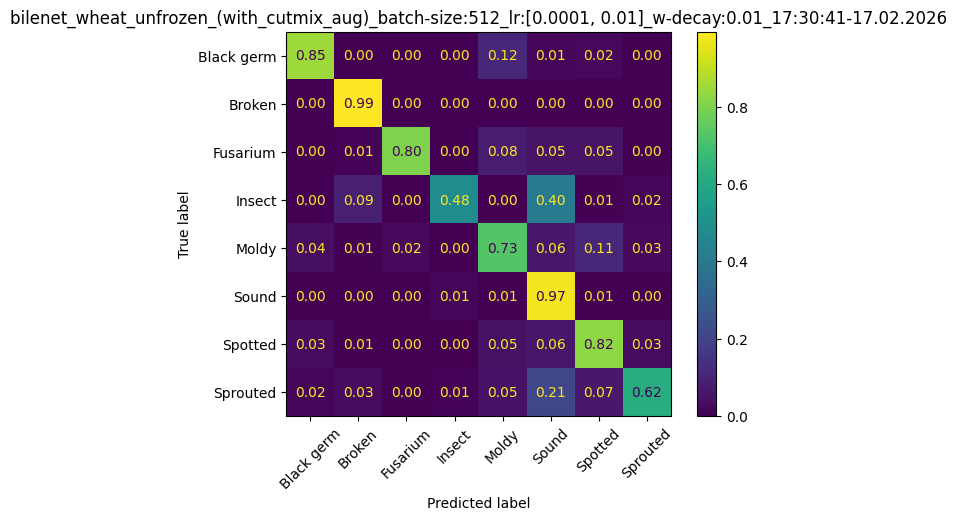

models/mobilenet_wheat_unfrozen_(with_mixup_aug)_batch-size:256_lr:[0.0001, 0.01]_w-decay:0.01_00:42:17-18.02.2026.pth
batch size:  256
Accuracy of the network on the 10000 test images: 88 %
Accuracy for class: Black germ is 84.8 %
Accuracy for class: Broken is 98.8 %
Accuracy for class: Fusarium is 84.1 %
Accuracy for class: Insect is 47.8 %
Accuracy for class: Moldy is 35.5 %
Accuracy for class: Sound is 97.4 %
Accuracy for class: Spotted is 89.7 %
Accuracy for class: Sprouted is 62.7 %


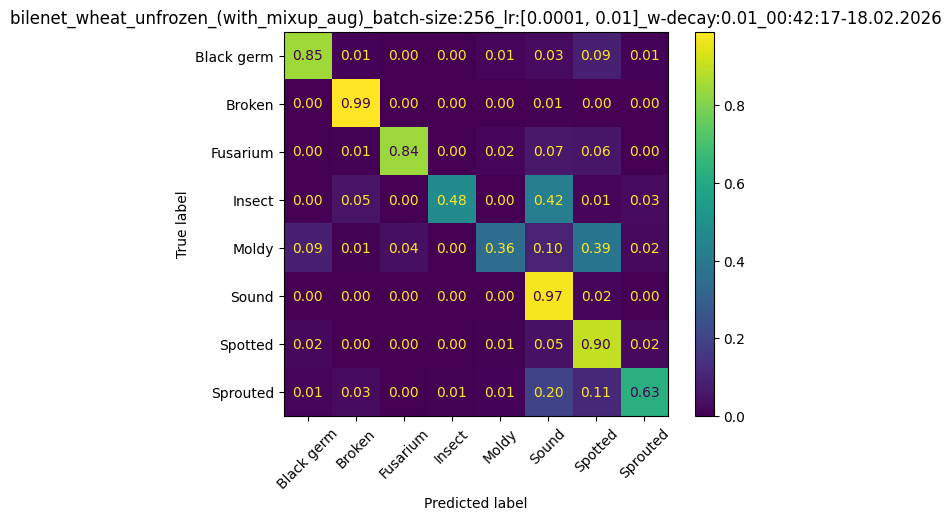

models/mobilenet_wheat_unfrozen_(with_mixup_aug)_batch-size:512_lr:[0.0001, 0.01]_w-decay:0.01_00:42:14-18.02.2026.pth
batch size:  512
Accuracy of the network on the 10000 test images: 87 %
Accuracy for class: Black germ is 60.2 %
Accuracy for class: Broken is 97.8 %
Accuracy for class: Fusarium is 76.8 %
Accuracy for class: Insect is 35.5 %
Accuracy for class: Moldy is 43.7 %
Accuracy for class: Sound is 98.1 %
Accuracy for class: Spotted is 84.5 %
Accuracy for class: Sprouted is 68.4 %


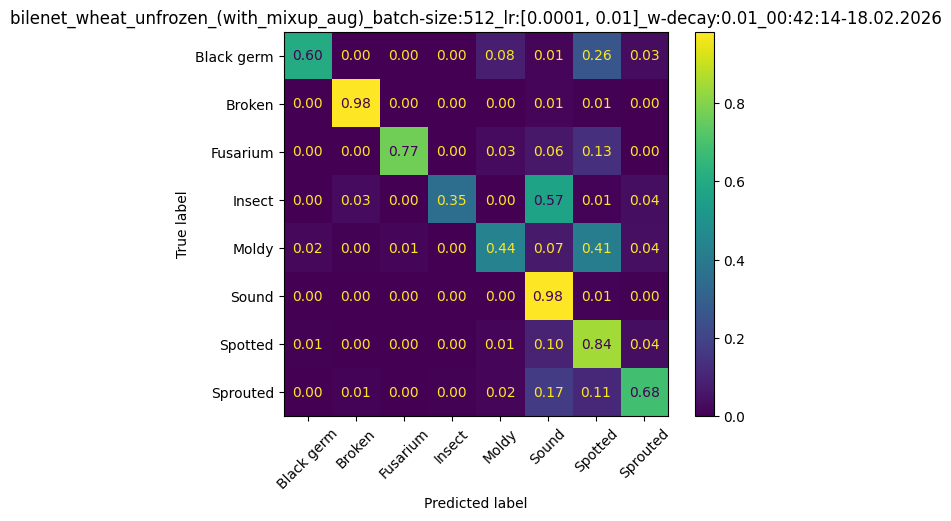

In [16]:
from wheat_data_prep import (
    TESTING_DATA as wheat_data,
    CLASSES as wheat_classes,
    data_loader as wheat_loader,
)

wheat_classes = list(wheat_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
wheat_paths = [
    "models/mobilenet_wheat_unfrozen_(with_cutmix_aug)_batch-size:256_lr:[0.0001, 0.01]_w-decay:0.01_17:30:26-17.02.2026.pth",
    "models/mobilenet_wheat_unfrozen_(with_cutmix_aug)_batch-size:512_lr:[0.0001, 0.01]_w-decay:0.01_17:30:41-17.02.2026.pth",
    "models/mobilenet_wheat_unfrozen_(with_mixup_aug)_batch-size:256_lr:[0.0001, 0.01]_w-decay:0.01_00:42:17-18.02.2026.pth",
    "models/mobilenet_wheat_unfrozen_(with_mixup_aug)_batch-size:512_lr:[0.0001, 0.01]_w-decay:0.01_00:42:14-18.02.2026.pth",
]
wheat_cm_data = []
for path in wheat_paths:
    print(path)
    print("batch size: ", get_batch_size(path))
    test_loader = wheat_loader(wheat_data, device, batch_size=get_batch_size(path), sampler=None)
    wheat_trues, wheat_preds = perform_eval(path, wheat_classes, test_loader)
    wheat_cm_data.append((path, wheat_trues, wheat_preds))
    wheat_title = path.strip("models/").strip(".pth")
    confusion_matrix(wheat_title, wheat_trues, wheat_preds, wheat_classes, 'true')